## DS 6040 - Project Proposal Update 

**Michael Davies (mld9s)**  
**Akeem Wells (ajw3rg)**  

#### 1. Couple of sentences reorienting me to your project

**Predicting Heart Disease**  

**Overview:**
“Heart disease has become a major health problem in both developed and developing countries, and it is cited as the number one cause of death throughout the world each year.” Given the risk of heart disease in modern society, detection of cardiovascular disease and identifying its risk level for adults is a critical task.

**Objectives:**
We will implement a model to classify whether a patient is normal or has heart disease. More specifically, we will develop a binary classification model that predicts the posterior probability that an individual has heart disease (given our data and model). 

#### 2. Have you obtained the data you need, and if so, what does it look like?

In short, we obtained the data and have completed preliminary cleaning, which can be seen below.

**Data**

The data we selected comes from:   
- Hungarian Institute of Cardiology. Budapest
- University Hospital, Zurich, Switzerland
- University Hospital, Basel, Switzerland
- V.A. Medical Center, Long Beach and Cleveland Clinic Foundation
[Source](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/) and [Source](https://www.kaggle.com/ronitf/heart-disease-uci)

Variables:
- ~76 Attributes available 
- ~14 Attributes used:
- age - age in years
- sex - (1 = male; 0 = female)
- cp - chest pain type
- trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- chol - serum cholesterol in mg/dl
- fbs - (fasting blood sugar &gt; 120 mg/dl) (1 = true; 0 = false)
- restecg - resting electrocardiographic results
- thalach - maximum heart rate achieved
- exang - exercise induced angina (1 = yes; 0 = no)
- oldpeak - ST depression induced by exercise relative to rest
- slope - the slope of the peak exercise ST segment
- ca - number of major vessels (0-3) colored by flourosopy
- thal - 3 = normal; 6 = fixed defect; 7 = reversible defect
- target (the predicted attribute) - 0/1

#### 3. Broadly, what Bayesian model/approach you are planning on using, and if you have already begun analyzing the data.

We plan to implement a Hierarchical Bayes Approach. This is appropriate given that our data contains the same feature but is drawn from from distinct locations: Budapest-Hungary, Zurich-Switzerland, Basel-Switzerland and the VA Medical Center (Long Beach and Cleveland).

Questions we have at this point are:
- How does pymc3 handle missing data?
- What data transformations are required (eg: scaling)?


## Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from itertools import combinations


import warnings
warnings.filterwarnings('ignore')
from mpmath import mp
mp.dps = 50

# pymc3 / arviz / theano
import arviz as az
import theano.tensor as T

from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, Deterministic
from pymc3 import forestplot, traceplot, plot_posterior
import pymc3 as pm

# scipy / statsmodels / sklearn
from sklearn.impute import KNNImputer

from scipy.stats import multivariate_normal
import statsmodels.api as sm
from statsmodels.tools import add_constant

#np.set_printoptions(threshold=np.inf)
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
#!nproc

In [ ]:
!rm -rf processed.cleveland.data*
!rm -rf processed.hungarian.data*
!rm -rf processed.switzerland.data*
!rm -rf processed.va.data*

In [ ]:
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data

--2021-08-11 23:11:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18461 (18K) [application/x-httpd-php]
Saving to: ‘processed.cleveland.data’

processed.cleveland 100%[===================>]  18.03K  --.-KB/s    in 0.1s    

2021-08-11 23:11:25 (122 KB/s) - ‘processed.cleveland.data’ saved [18461/18461]

--2021-08-11 23:11:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10263 (10K) [application/x-httpd-php]
Saving to: ‘processed.hungarian.data’

processed.

In [ ]:
ls

age_histplot.png                          hierarchical_trace_subset_mu.png
BMA_Logit_summary.tex                     hierarchical_trace_subset.png
ca_histplot.png                           logistic_model_trace_full.png
chol_histplot.png                         logistic_model_trace_subset.png
corr_heatmap.png                          logistic_model_trace_summary.tex
country_histplot.png                      oldpeak_histplot.png
cp_histplot.png                           pairplot_by_country.png
data_describe_scaled.tex                  pairplot_by_target.png
data_describe.tex                         processed.cleveland.data
exang_histplot.png                        processed.hungarian.data
fbs_histplot.png                          processed.switzerland.data
final_summary_BMA.tex                     processed.va.data
final_summary_hierarchical.tex            restecg_histplot.png
final_summary_logistic.tex                sample_data/
hierarchical_trace_full_marginals.png     sex_histplot.pn

#### Import Data

In [ ]:
def load_data(infile):
    matrix = []
    file = open(infile, "r")
    tmp = file.read()
    for i in range(len(tmp.split("\n"))):
        if len(tmp.split("\n")[i].split(',')) == 14:
            row = tmp.split("\n")[i].split(',')
            matrix.append(row)
    file.close()
    return matrix

#### Data merging and cleaning

In [ ]:
columns = ["age","sex","cp","trestbps","chol","fbs", "restecg",
        "thalach", "exang","oldpeak","slope", "ca","thal","target"]

nan_map = {'?':np.nan}

df_processed_hungarian = pd.DataFrame(load_data("processed.hungarian.data"))
df_processed_hungarian.columns = columns
df_processed_hungarian = df_processed_hungarian.replace(nan_map)
df_processed_hungarian.insert(0, "country", "hungary")

df_processed_va = pd.DataFrame(load_data("processed.va.data"))
df_processed_va.columns = columns
df_processed_va = df_processed_va.replace(nan_map)
df_processed_va.insert(0, "country", "va-longbeach")

df_processed_switzerland = pd.DataFrame(load_data("processed.switzerland.data"))
df_processed_switzerland.columns = columns
df_processed_switzerland = df_processed_switzerland.replace(nan_map)
df_processed_switzerland.insert(0, "country", "switzerland")
df_processed_switzerland[columns].replace(nan_map)

df_processed_cleveland = pd.DataFrame(load_data("processed.cleveland.data"))
df_processed_cleveland.columns = columns
df_processed_cleveland = df_processed_cleveland.replace(nan_map)
df_processed_cleveland.insert(0, "country", "cleveland")

In [ ]:
print(df_processed_switzerland.shape)
df_processed_switzerland.head()

(123, 15)


country age sex cp trestbps chol  ... exang oldpeak slope   ca thal target
0  switzerland  32   1  1       95    0  ...     0      .7     1  NaN  NaN      1
1  switzerland  34   1  4      115    0  ...     0      .2     1  NaN  NaN      1
2  switzerland  35   1  4      NaN    0  ...     1     NaN   NaN  NaN    7      3
3  switzerland  36   1  4      110    0  ...     1       1     2  NaN    6      1
4  switzerland  38   0  4      105    0  ...     0     2.8     1  NaN  NaN      2

[5 rows x 15 columns]

In [ ]:
print(df_processed_cleveland.shape)
df_processed_cleveland.head()

(303, 15)


country   age  sex   cp trestbps  ... oldpeak slope   ca thal target
0  cleveland  63.0  1.0  1.0    145.0  ...     2.3   3.0  0.0  6.0      0
1  cleveland  67.0  1.0  4.0    160.0  ...     1.5   2.0  3.0  3.0      2
2  cleveland  67.0  1.0  4.0    120.0  ...     2.6   2.0  2.0  7.0      1
3  cleveland  37.0  1.0  3.0    130.0  ...     3.5   3.0  0.0  3.0      0
4  cleveland  41.0  0.0  2.0    130.0  ...     1.4   1.0  0.0  3.0      0

[5 rows x 15 columns]

In [ ]:
print(df_processed_va.shape)
df_processed_va.head()

(200, 15)


country age sex cp trestbps chol  ... exang oldpeak slope   ca thal target
0  va-longbeach  63   1  4      140  260  ...     1       3     2  NaN  NaN      2
1  va-longbeach  44   1  4      130  209  ...     0       0   NaN  NaN  NaN      0
2  va-longbeach  60   1  4      132  218  ...     1     1.5     3  NaN  NaN      2
3  va-longbeach  55   1  4      142  228  ...     1     2.5     1  NaN  NaN      1
4  va-longbeach  66   1  3      110  213  ...     1     1.3     2  NaN  NaN      0

[5 rows x 15 columns]

In [ ]:
print(df_processed_hungarian.shape)
df_processed_hungarian.head()

(294, 15)


country age sex cp trestbps chol  ... exang oldpeak slope   ca thal target
0  hungary  28   1  2      130  132  ...     0       0   NaN  NaN  NaN      0
1  hungary  29   1  2      120  243  ...     0       0   NaN  NaN  NaN      0
2  hungary  29   1  2      140  NaN  ...     0       0   NaN  NaN  NaN      0
3  hungary  30   0  1      170  237  ...     0       0   NaN  NaN    6      0
4  hungary  31   0  2      100  219  ...     0       0   NaN  NaN  NaN      0

[5 rows x 15 columns]

#### Merge all countries into one dataset

In [ ]:
def convert_float_to_int(df, variable):
    df[variable] = df[variable].apply(lambda x: int(float(x)) if pd.notnull(x) else x)
    
    # To make columns into  float
    df[variable] = df[variable].astype('float')
    
    ## To make columns into ints
    #df[variable] = df[variable].astype('Int64')

In [ ]:
convert_columns = ["age","sex","cp","trestbps","chol","fbs", 
                   "restecg","thalach", "exang","slope", "ca","thal","target"]
for variable in convert_columns:
    convert_float_to_int(df_processed_switzerland, variable)
    convert_float_to_int(df_processed_cleveland, variable)
    convert_float_to_int(df_processed_va, variable)
    convert_float_to_int(df_processed_hungarian, variable)
       

In [ ]:
countries = (df_processed_switzerland, df_processed_cleveland, df_processed_va, df_processed_hungarian)
df = pd.concat(countries) # ignore_index=True

df['target'] = df['target'].apply(lambda x: 0 if int(x) == 0 else 1)
print(df.shape)

(920, 15)


In [ ]:
#df.dropna(inplace=True)
print(df.shape)
df.sample(10)

(920, 15)


country   age  sex   cp  trestbps  ...  oldpeak  slope   ca  thal  target
63   va-longbeach  56.0  1.0  3.0     170.0  ...      2.5    NaN  NaN   NaN       1
54    switzerland  55.0  1.0  4.0     140.0  ...        0    2.0  NaN   7.0       1
164       hungary  55.0  1.0  4.0     120.0  ...        0    NaN  NaN   NaN       0
166       hungary  56.0  0.0  3.0     130.0  ...        0    NaN  NaN   7.0       0
253       hungary  44.0  1.0  2.0     150.0  ...        3    2.0  NaN   NaN       1
219       hungary  57.0  1.0  2.0     140.0  ...        1    2.0  NaN   NaN       1
263     cleveland  44.0  1.0  3.0     120.0  ...      0.0    1.0  0.0   3.0       0
211       hungary  49.0  1.0  4.0     130.0  ...        0    NaN  NaN   NaN       1
4       cleveland  41.0  0.0  2.0     130.0  ...      1.4    1.0  0.0   3.0       0
6         hungary  32.0  1.0  2.0     110.0  ...        0    NaN  NaN   NaN       0

[10 rows x 15 columns]

#### Clean dtypes

In [ ]:
# coercing categorical and discrete values to category type
categ_cols = ['country', 'sex', 'target', 'cp', 'fbs', 'exang', 'ca', 
               'thal', 'slope', 'restecg']
int_cols = [col for col in df.columns if col not in categ_cols]

df[categ_cols] = df[categ_cols].astype('category')
df[int_cols] = df[int_cols].apply(pd.to_numeric)
pd.DataFrame(df.dtypes)

0
country   category
age        float64
sex       category
cp        category
trestbps   float64
chol       float64
fbs       category
restecg   category
thalach    float64
exang     category
oldpeak    float64
slope     category
ca        category
thal      category
target    category

In [ ]:
f = open("data_describe.tex", "w")
f.write(df.describe().to_latex())
f.close()
df.describe()

age    trestbps        chol     thalach     oldpeak
count  920.000000  861.000000  890.000000  865.000000  858.000000
mean    53.510870  132.132404  199.130337  137.545665    0.878788
std      9.424685   19.066070  110.780810   25.926276    1.091226
min     28.000000    0.000000    0.000000   60.000000   -2.600000
25%     47.000000  120.000000  175.000000  120.000000    0.000000
50%     54.000000  130.000000  223.000000  140.000000    0.500000
75%     60.000000  140.000000  268.000000  157.000000    1.500000
max     77.000000  200.000000  603.000000  202.000000    6.200000

In [ ]:
!pwd

/content


#### Check class balances on response var

In [ ]:
df.target.value_counts()

1    509
0    411
Name: target, dtype: int64

Initial EDA

<Figure size 864x720 with 0 Axes>

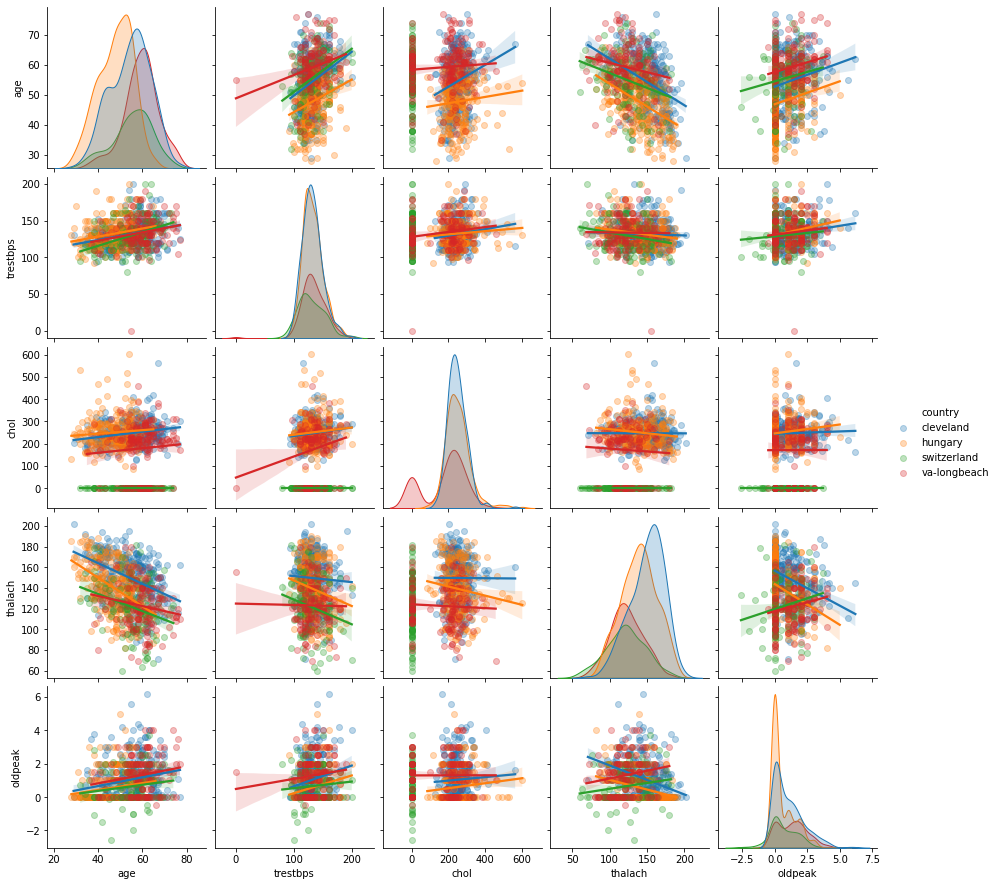

In [ ]:
plt.figure(figsize=(12,10))
sns.pairplot(df, hue='country', kind="reg", plot_kws={'scatter_kws': {'alpha': 0.3}})
plt.savefig("pairplot_by_country.png")

<Figure size 864x720 with 0 Axes>

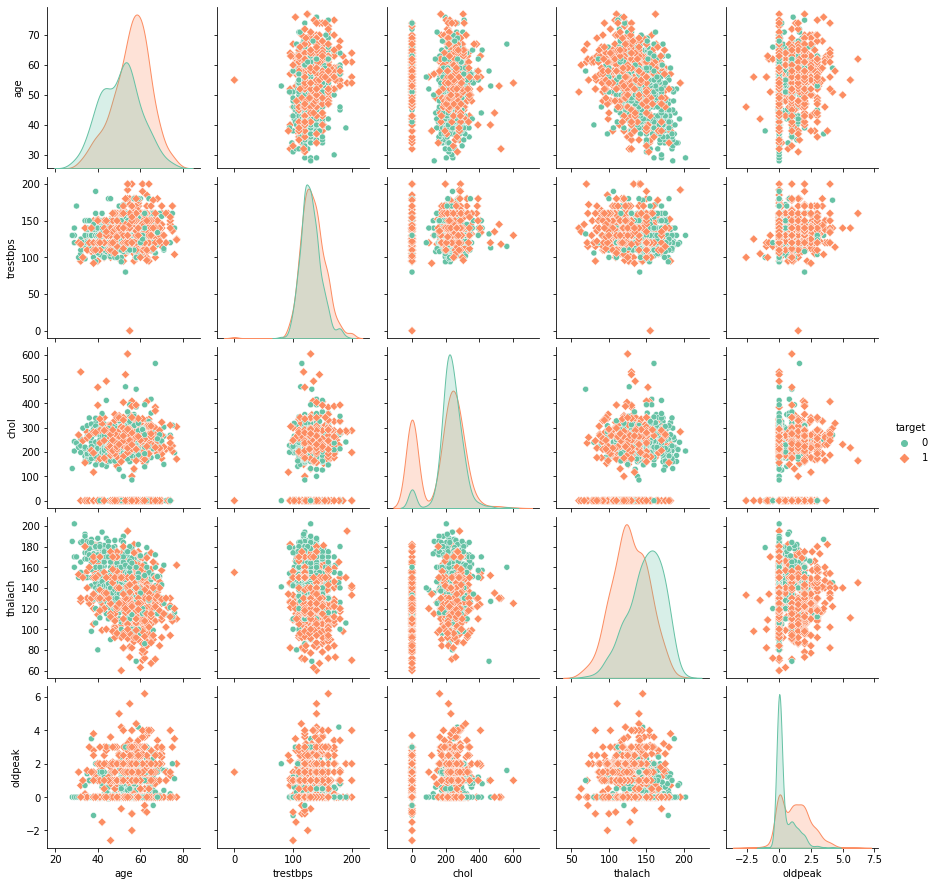

In [ ]:
plt.figure(figsize=(12,10))
sns.pairplot(df, hue="target", palette="Set2", markers=["o", "D"]);
plt.savefig("pairplot_by_target.png")

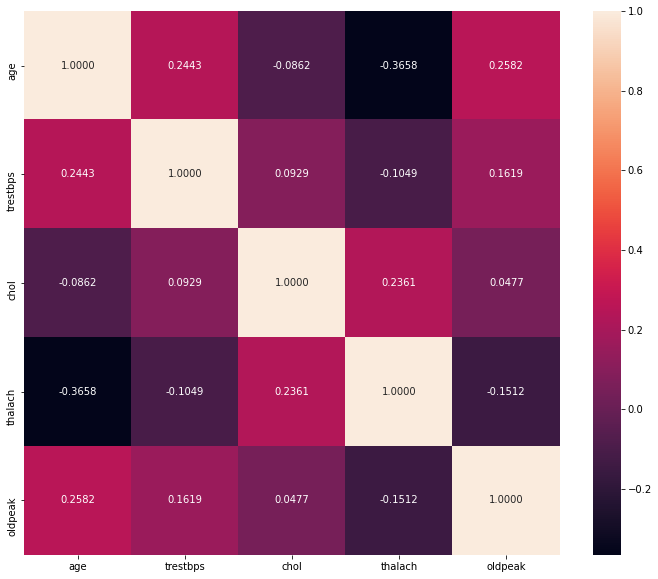

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,fmt='.4f');
plt.savefig("corr_heatmap.png")

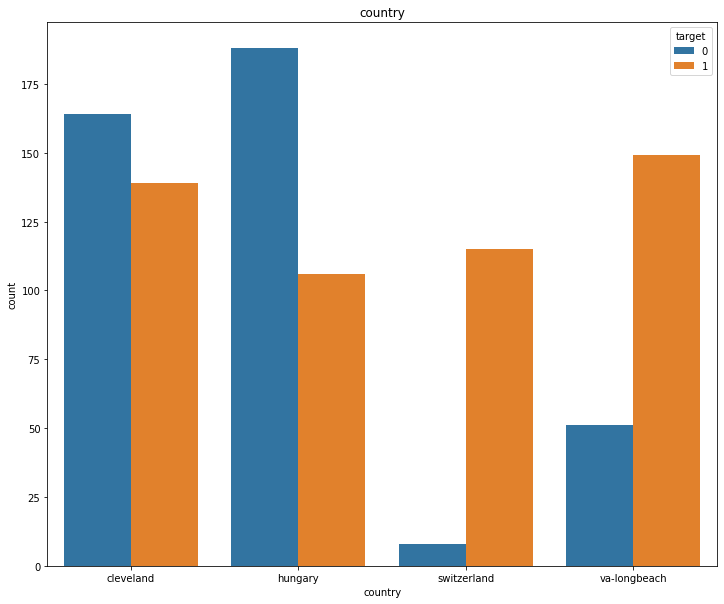

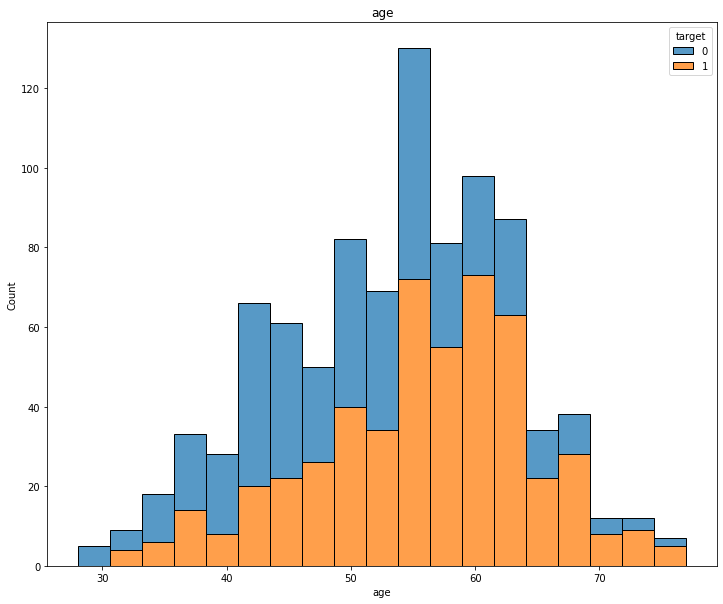

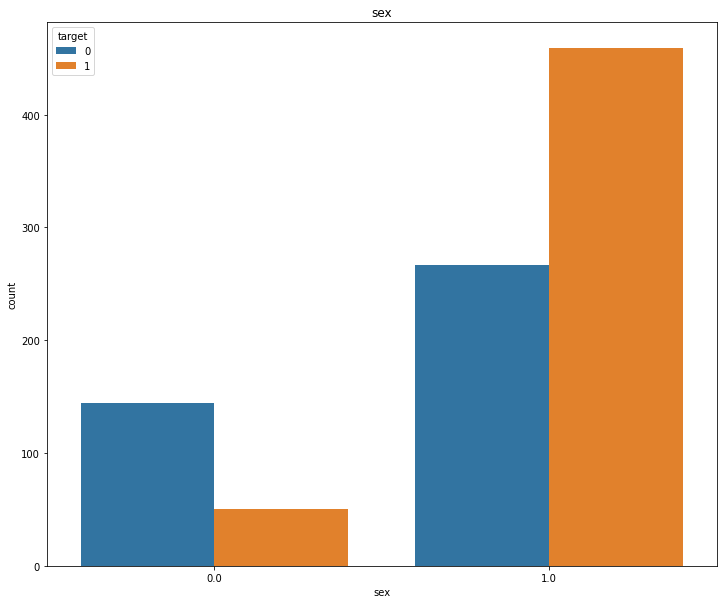

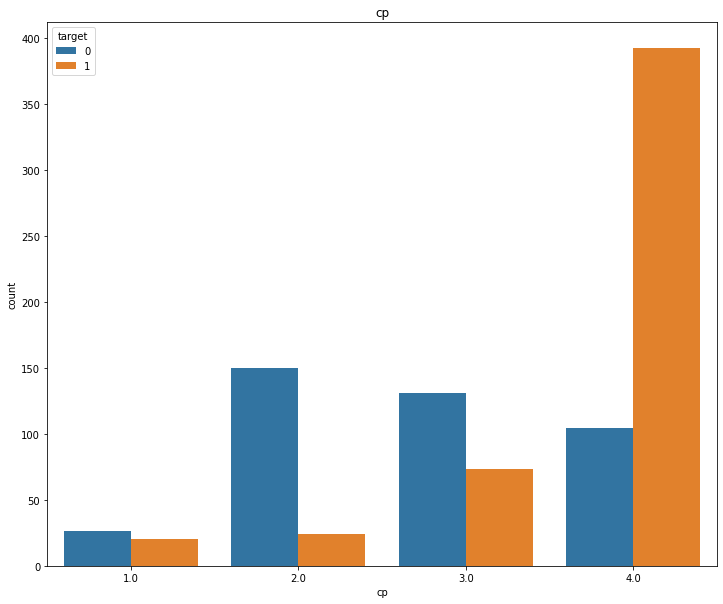

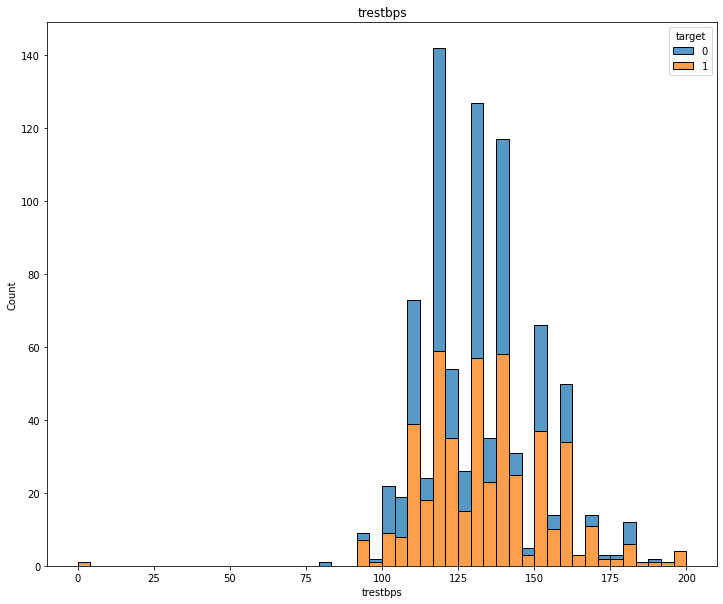

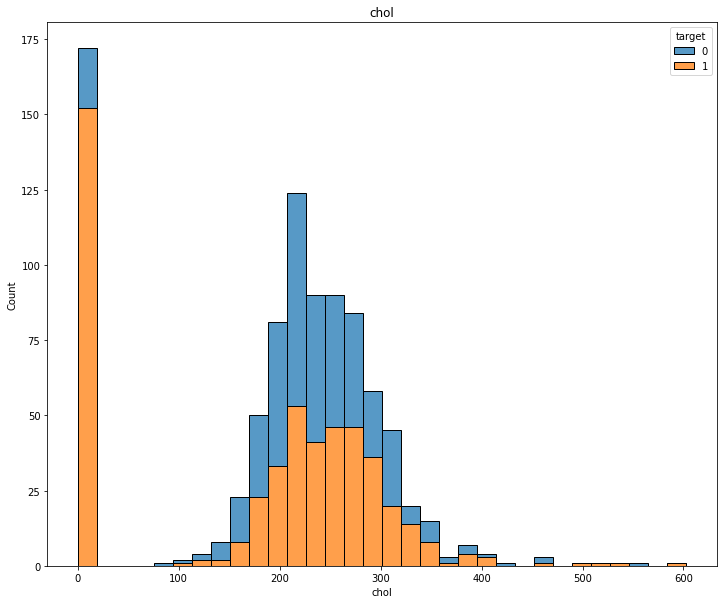

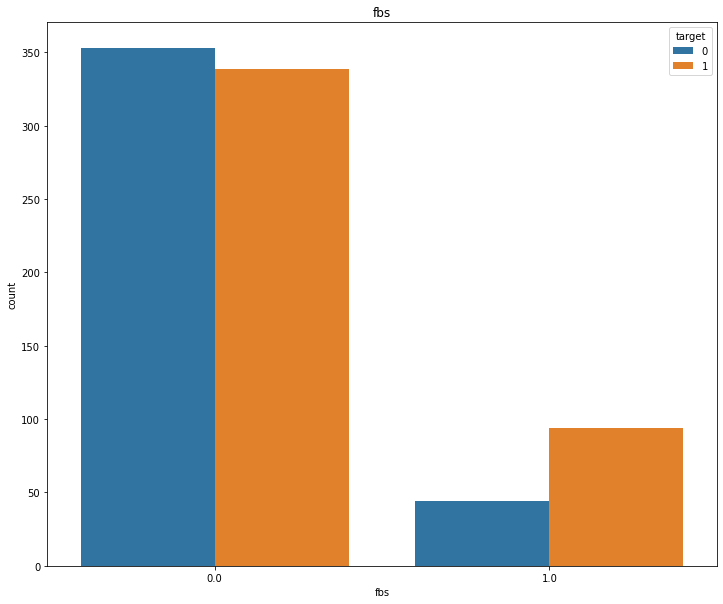

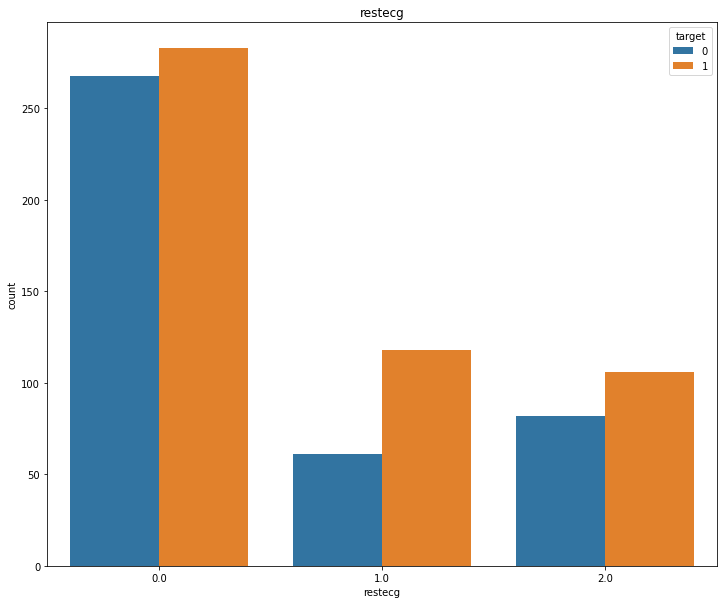

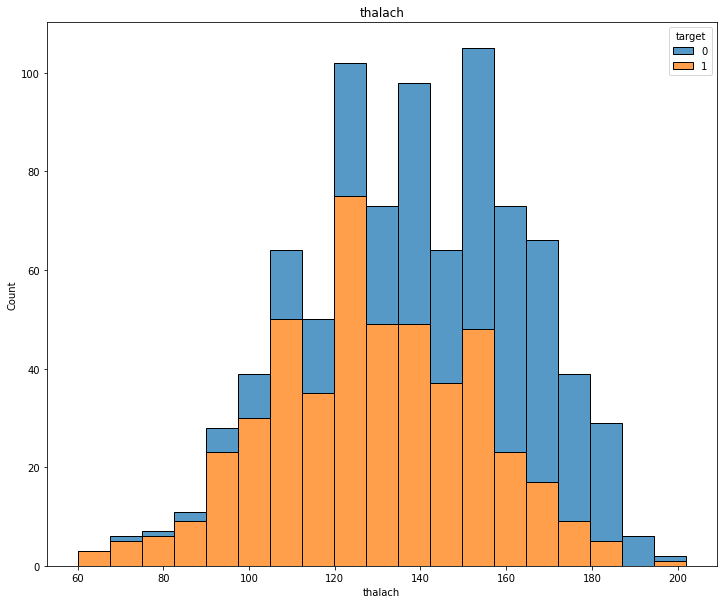

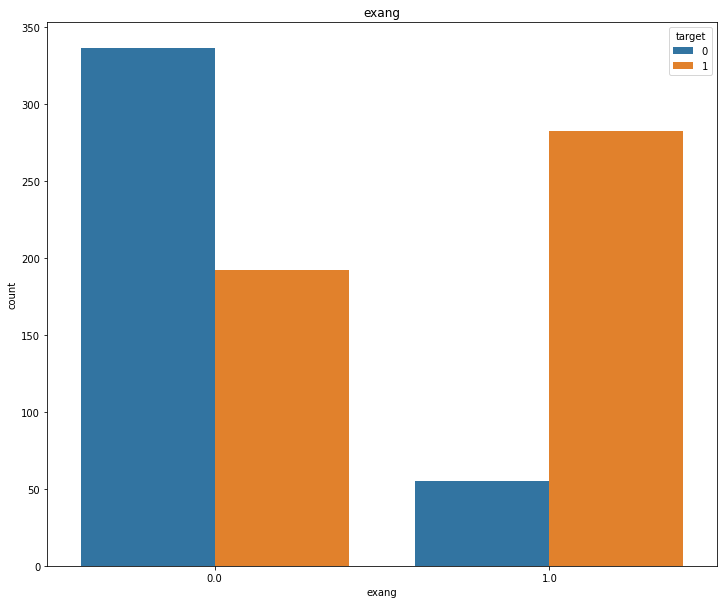

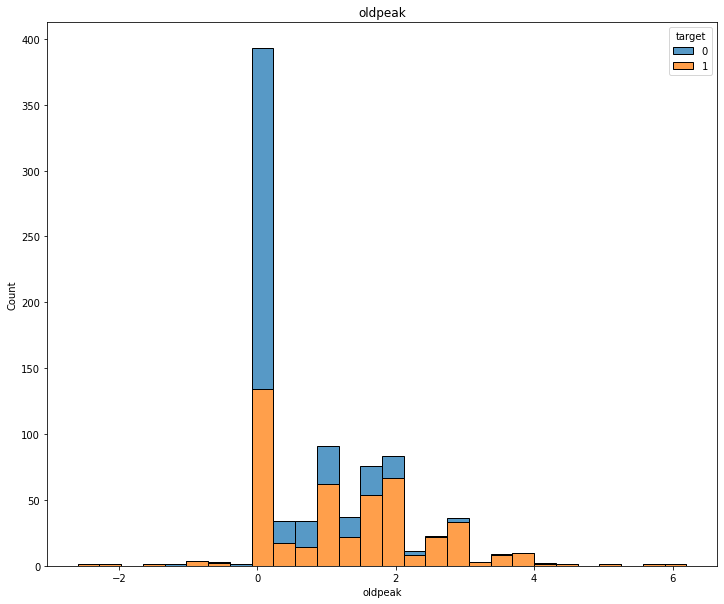

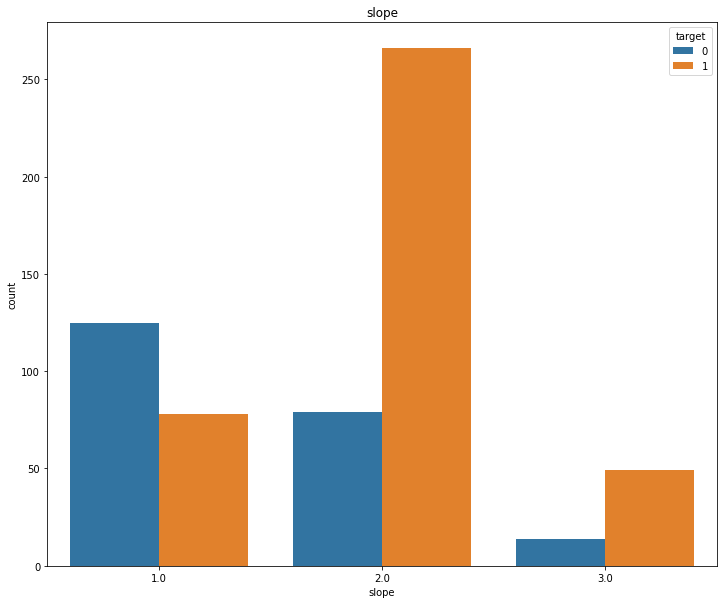

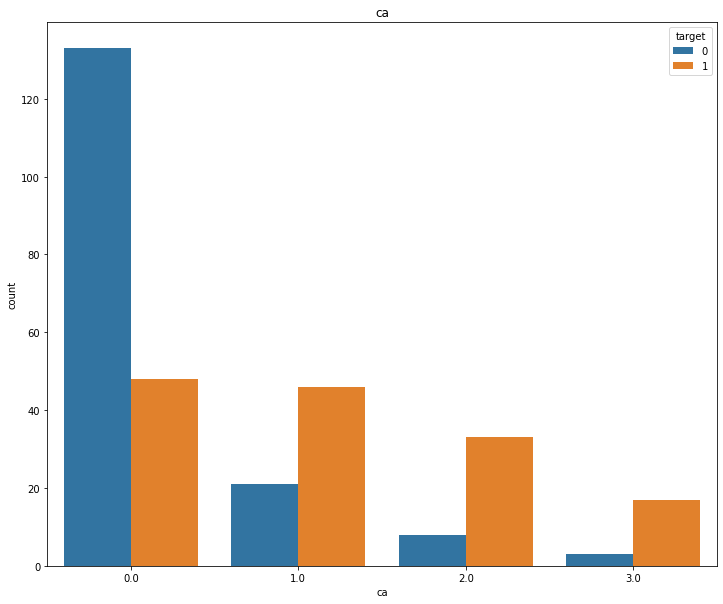

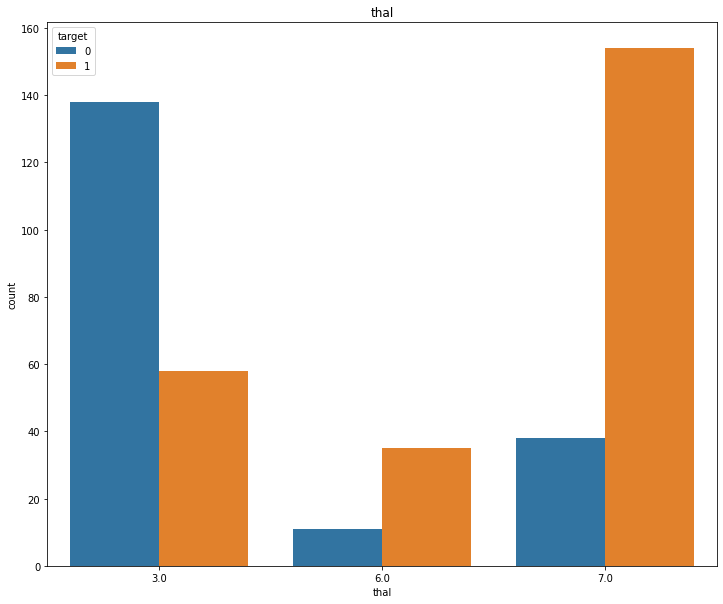

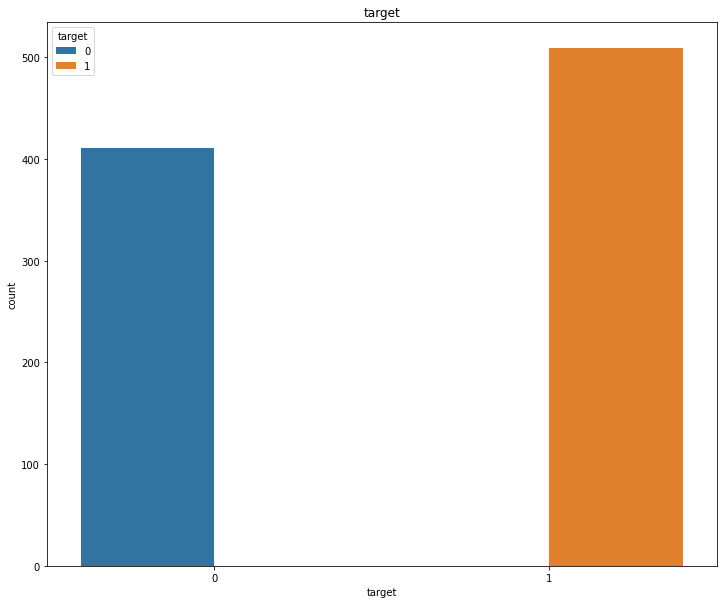

In [ ]:
for col in df.columns:
  plt.figure(figsize=(12,10))
  if len(df[col].unique()) < 7:
    sns.countplot(data= df, x=col,hue='target')
  else:
    sns.histplot(data=df, x=col, hue='target', multiple="stack")
  plt.title('{}'.format(col))
  plt.savefig("{}_histplot.png".format(col))

In [ ]:
#for col in sorted(df.columns):
#  print('\\begin{figure}[hbt!]')
#  print('    \centering')
#  print('    \includegraphics[width=0.7\\textwidth]{"'+ col +'_histplot.png"}')
#  print('    \caption{'+ col.capitalize() + ' Histogram}')
#  print('\end{figure}')
#  print('')


In [ ]:
# for i in categ_cols:
#     ct = pd.crosstab(df.country, df[i])
#     print("")
#     print(ct)

#Imputer

In [ ]:
df.head()

country   age  sex   cp  trestbps  ...  oldpeak slope  ca  thal target
0  switzerland  32.0  1.0  1.0      95.0  ...      0.7   1.0 NaN   NaN      1
1  switzerland  34.0  1.0  4.0     115.0  ...      0.2   1.0 NaN   NaN      1
2  switzerland  35.0  1.0  4.0       NaN  ...      NaN   NaN NaN   7.0      1
3  switzerland  36.0  1.0  4.0     110.0  ...      1.0   2.0 NaN   6.0      1
4  switzerland  38.0  0.0  4.0     105.0  ...      2.8   1.0 NaN   NaN      1

[5 rows x 15 columns]

In [ ]:
df_orig = df.copy(deep = True)

In [ ]:
# Checkpoint
df = df_orig.copy(deep = True)

In [ ]:
df.head()

country   age  sex   cp  trestbps  ...  oldpeak slope  ca  thal target
0  switzerland  32.0  1.0  1.0      95.0  ...      0.7   1.0 NaN   NaN      1
1  switzerland  34.0  1.0  4.0     115.0  ...      0.2   1.0 NaN   NaN      1
2  switzerland  35.0  1.0  4.0       NaN  ...      NaN   NaN NaN   7.0      1
3  switzerland  36.0  1.0  4.0     110.0  ...      1.0   2.0 NaN   6.0      1
4  switzerland  38.0  0.0  4.0     105.0  ...      2.8   1.0 NaN   NaN      1

[5 rows x 15 columns]

In [ ]:
df_list = []
for country in df.country.unique():
  #print(country)
  subset = df[df['country'] == country]
  #print(subset.head())
  imputer = KNNImputer(n_neighbors=1)
  outframe = pd.DataFrame(imputer.fit_transform(subset[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']]), columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'])
  outframe.insert(0, "country", country)
  df_list.append(outframe)
df = pd.concat(df_list, axis=0)
df.head()

country   age  sex   cp  trestbps  ...  oldpeak  slope   ca  thal  target
0  switzerland  32.0  1.0  1.0      95.0  ...      0.7    1.0  1.0   7.0     1.0
1  switzerland  34.0  1.0  4.0     115.0  ...      0.2    1.0  1.0   3.0     1.0
2  switzerland  35.0  1.0  4.0     115.0  ...      0.0    2.0  1.0   7.0     1.0
3  switzerland  36.0  1.0  4.0     110.0  ...      1.0    2.0  1.0   6.0     1.0
4  switzerland  38.0  0.0  4.0     105.0  ...      2.8    1.0  1.0   3.0     1.0

[5 rows x 15 columns]

In [ ]:
#for var in df.columns:
#    # counting unique values
#    n1 = len(pd.unique(df_orig[str(var)]))
#    n2 = len(pd.unique(df[str(var)]))
#    print("Col: {}, \n \tunique from old: {} \n\tunique from new: {}".format(var, n1, n2))
#
#    if n1 < 5:
#      print(pd.unique(df_orig[str(var)]))
#      print(pd.unique(df[str(var)]))
#

In [ ]:
# coercing categorical and discrete values to category type
categ_cols = ['country', 'sex', 'target', 'cp', 'fbs', 'exang', 'ca', 
               'thal', 'slope', 'restecg']
int_cols = [col for col in df.columns if col not in categ_cols]

df[categ_cols] = df[categ_cols].astype('category')
df[int_cols] = df[int_cols].apply(pd.to_numeric)

In [ ]:
df.head()

country   age  sex   cp  trestbps  ...  oldpeak slope   ca  thal target
0  switzerland  32.0  1.0  1.0      95.0  ...      0.7   1.0  1.0   7.0    1.0
1  switzerland  34.0  1.0  4.0     115.0  ...      0.2   1.0  1.0   3.0    1.0
2  switzerland  35.0  1.0  4.0     115.0  ...      0.0   2.0  1.0   7.0    1.0
3  switzerland  36.0  1.0  4.0     110.0  ...      1.0   2.0  1.0   6.0    1.0
4  switzerland  38.0  0.0  4.0     105.0  ...      2.8   1.0  1.0   3.0    1.0

[5 rows x 15 columns]

In [ ]:
def find_id(x):
  return ['switzerland', 'cleveland', 'va-longbeach', 'hungary'].index(x)
df['id'] = [ find_id(x) for x in df['country']]
df['id'] = df['id'].astype('category')

# Scaling

https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

In [ ]:
# apply the z-score method in Pandas using the .mean() and .std() methods
def z_score(df):
    # copy the dataframe
    df_std = df.copy(deep=True)
    # apply the z-score method
    for column in df_std.columns:
        if str(df_std[column].dtypes) == 'category': continue
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std

In [ ]:
def maximum_absolute_scaling(df):
    # copy the dataframe
    df_scaled = df.copy(deep=True)
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        if str(df_scaled[column].dtypes) == 'category': continue
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled

In [ ]:
print(df.head())

#scaleType = 'zscore'
scaleType = 'maxabs'
#scaleType = 'noscale'

if scaleType == 'zscore':
  df_standardized = z_score(df)

elif scaleType == 'maxabs':
  df_standardized = maximum_absolute_scaling(df)

elif scaleType == 'noscale':
  df_standardized = df

print(df_standardized.head())

       country   age  sex   cp  trestbps  ...  slope   ca thal  target id
0  switzerland  32.0  1.0  1.0      95.0  ...    1.0  1.0  7.0     1.0  0
1  switzerland  34.0  1.0  4.0     115.0  ...    1.0  1.0  3.0     1.0  0
2  switzerland  35.0  1.0  4.0     115.0  ...    2.0  1.0  7.0     1.0  0
3  switzerland  36.0  1.0  4.0     110.0  ...    2.0  1.0  6.0     1.0  0
4  switzerland  38.0  0.0  4.0     105.0  ...    1.0  1.0  3.0     1.0  0

[5 rows x 16 columns]
       country       age  sex   cp  trestbps  ...  slope   ca thal  target id
0  switzerland  0.415584  1.0  1.0     0.475  ...    1.0  1.0  7.0     1.0  0
1  switzerland  0.441558  1.0  4.0     0.575  ...    1.0  1.0  3.0     1.0  0
2  switzerland  0.454545  1.0  4.0     0.575  ...    2.0  1.0  7.0     1.0  0
3  switzerland  0.467532  1.0  4.0     0.550  ...    2.0  1.0  6.0     1.0  0
4  switzerland  0.493506  0.0  4.0     0.525  ...    1.0  1.0  3.0     1.0  0

[5 rows x 16 columns]


In [ ]:
df = df_standardized

In [ ]:
f = open("data_describe_scaled.tex", "w")
f.write(df.describe().to_latex())
f.close()
df.describe()

age    trestbps        chol     thalach     oldpeak
count  920.000000  920.000000  920.000000  920.000000  920.000000
mean     0.694946    0.660533    0.333164    0.677513    0.146564
std      0.122399    0.094100    0.183888    0.127336    0.175852
min      0.363636    0.000000    0.000000    0.297030   -0.419355
25%      0.610390    0.600000    0.293532    0.589109    0.000000
50%      0.701299    0.650000    0.371476    0.688119    0.096774
75%      0.779221    0.700000    0.447761    0.772277    0.241935
max      1.000000    1.000000    1.000000    1.000000    1.000000

In [ ]:
df.head()

country       age  sex   cp  trestbps  ...  slope   ca thal  target id
0  switzerland  0.415584  1.0  1.0     0.475  ...    1.0  1.0  7.0     1.0  0
1  switzerland  0.441558  1.0  4.0     0.575  ...    1.0  1.0  3.0     1.0  0
2  switzerland  0.454545  1.0  4.0     0.575  ...    2.0  1.0  7.0     1.0  0
3  switzerland  0.467532  1.0  4.0     0.550  ...    2.0  1.0  6.0     1.0  0
4  switzerland  0.493506  0.0  4.0     0.525  ...    1.0  1.0  3.0     1.0  0

[5 rows x 16 columns]

# Algorithms Initial Concept Testing

https://towardsdatascience.com/building-a-bayesian-logistic-regression-with-python-and-pymc3-4dd463bbb16

In [ ]:
y_simple = df['target']
x_n = 'age' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()
with pm.Model() as model_simple:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu_ = alpha + pm.math.dot(x_c, beta)    
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu_))
    bd = pm.Deterministic('bd', -alpha/beta)
    
    y_1 = pm.Bernoulli('y_1', p=theta, observed=y_simple)

    trace_simple = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


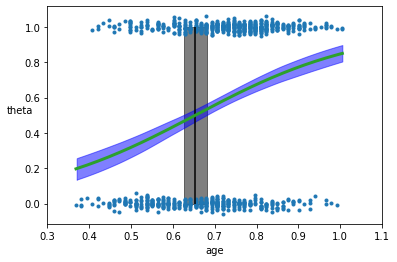

In [ ]:
theta = trace_simple['theta'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_simple['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hdi(trace_simple['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_simple, 0.02),
            marker='.')#, color=[f'C{x}' for x in y_simple])
az.plot_hdi(x_c, trace_simple['theta'], color='b')

plt.xlabel(x_n)
plt.ylabel('theta', rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));

In [ ]:
az.summary(trace_simple, var_names=['alpha', 'beta'])

mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.231  0.068   0.107    0.364  ...    0.001    1701.0    1268.0    1.0
beta   4.978  0.606   3.884    6.152  ...    0.010    1898.0    1508.0    1.0

[2 rows x 9 columns]

# Logistic Model with pmc3

In [ ]:
test_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
string = ' + '.join(test_columns)

In [ ]:
df.sample(5)

country       age  sex   cp  trestbps  ...  slope   ca thal  target id
78   va-longbeach  0.779221  1.0  4.0     0.710  ...    2.0  0.0  7.0     1.0  2
290       hungary  0.701299  0.0  3.0     0.650  ...    2.0  0.0  3.0     1.0  3
176     cleveland  0.675325  1.0  4.0     0.540  ...    1.0  3.0  7.0     0.0  1
28   va-longbeach  0.727273  1.0  4.0     0.600  ...    2.0  0.0  7.0     1.0  2
114   switzerland  0.883117  1.0  4.0     0.675  ...    1.0  1.0  7.0     1.0  0

[5 rows x 16 columns]

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [oldpeak, thalach, chol, trestbps, age, thal[T.7.0], thal[T.6.0], ca[T.3.0], ca[T.2.0], ca[T.1.0], slope[T.3.0], slope[T.2.0], exang[T.1.0], restecg[T.2.0], restecg[T.1.0], fbs[T.1.0], cp[T.4.0], cp[T.3.0], cp[T.2.0], sex[T.1.0], Intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 180 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec7eb8f4d0>,
      dtype=object)

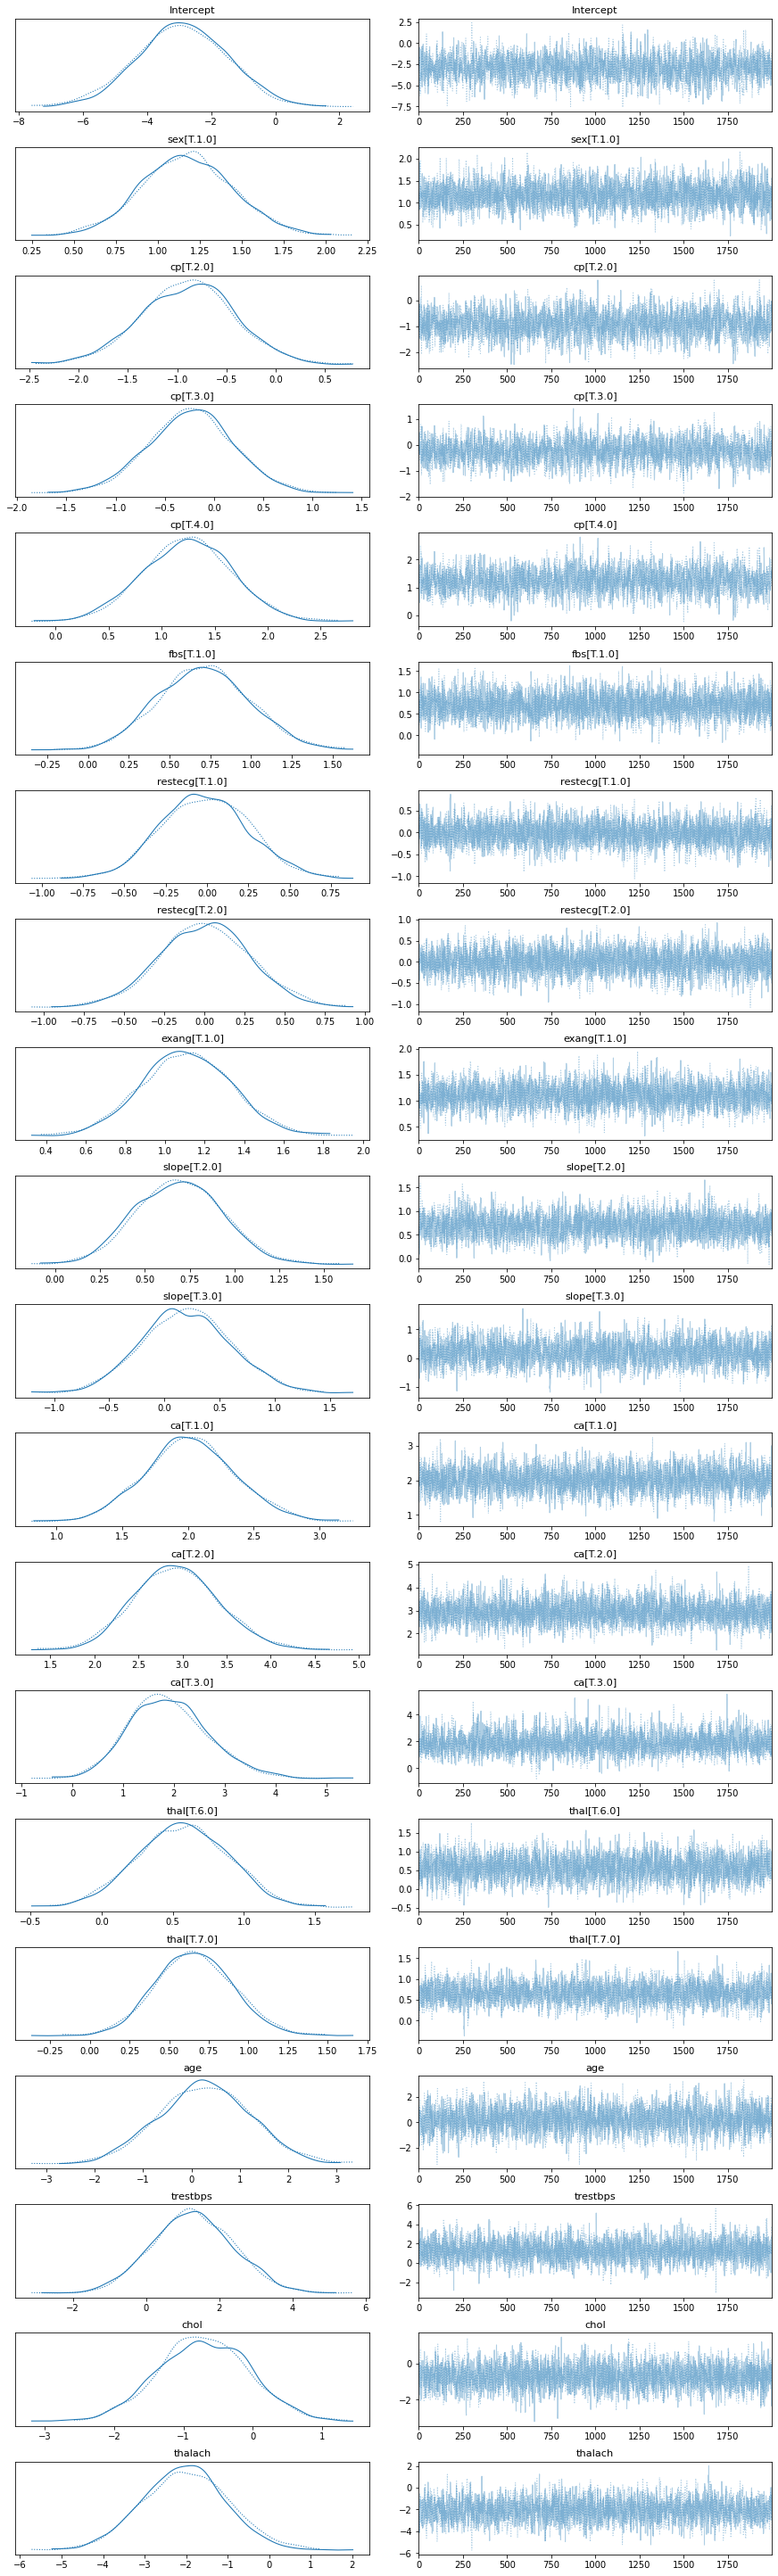

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('target ~ {}'.format(string), df, family = pm.glm.families.Binomial())
    trace = pm.sample(2000, tune = 2000, init = 'adapt_diag')
#az.plot_trace(trace);
az.plot_trace(trace, compact=True);

In [ ]:
df_tmp = pm.summary(trace)

In [ ]:
var_order = [ row for row in df_tmp.sort_values(by=['mean'], ascending=False, key=lambda x: abs(x)).index]
var_order.remove('Intercept')

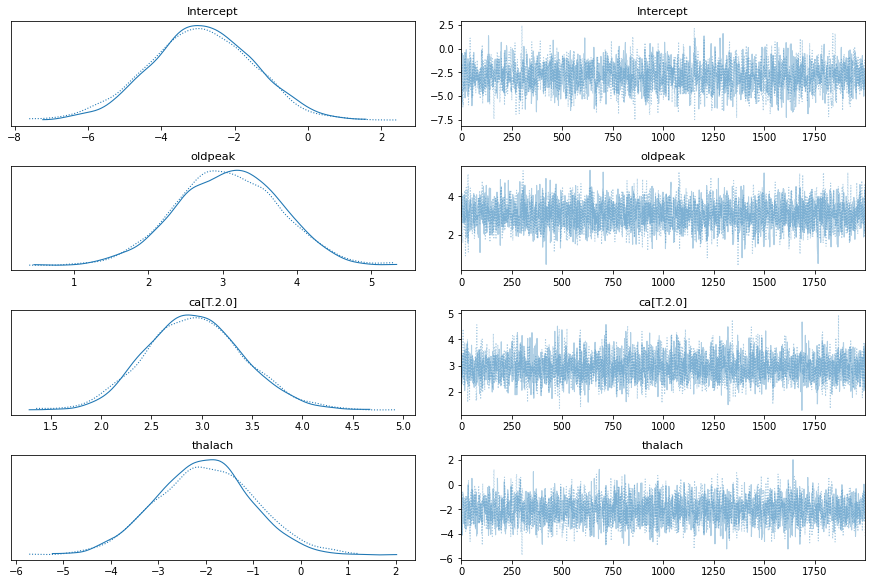

In [ ]:
axes = az.plot_trace(trace, var_names=['Intercept'] + var_order[0:3])
fig = axes.ravel()[0].figure
fig.savefig("logistic_model_trace_subset.png")

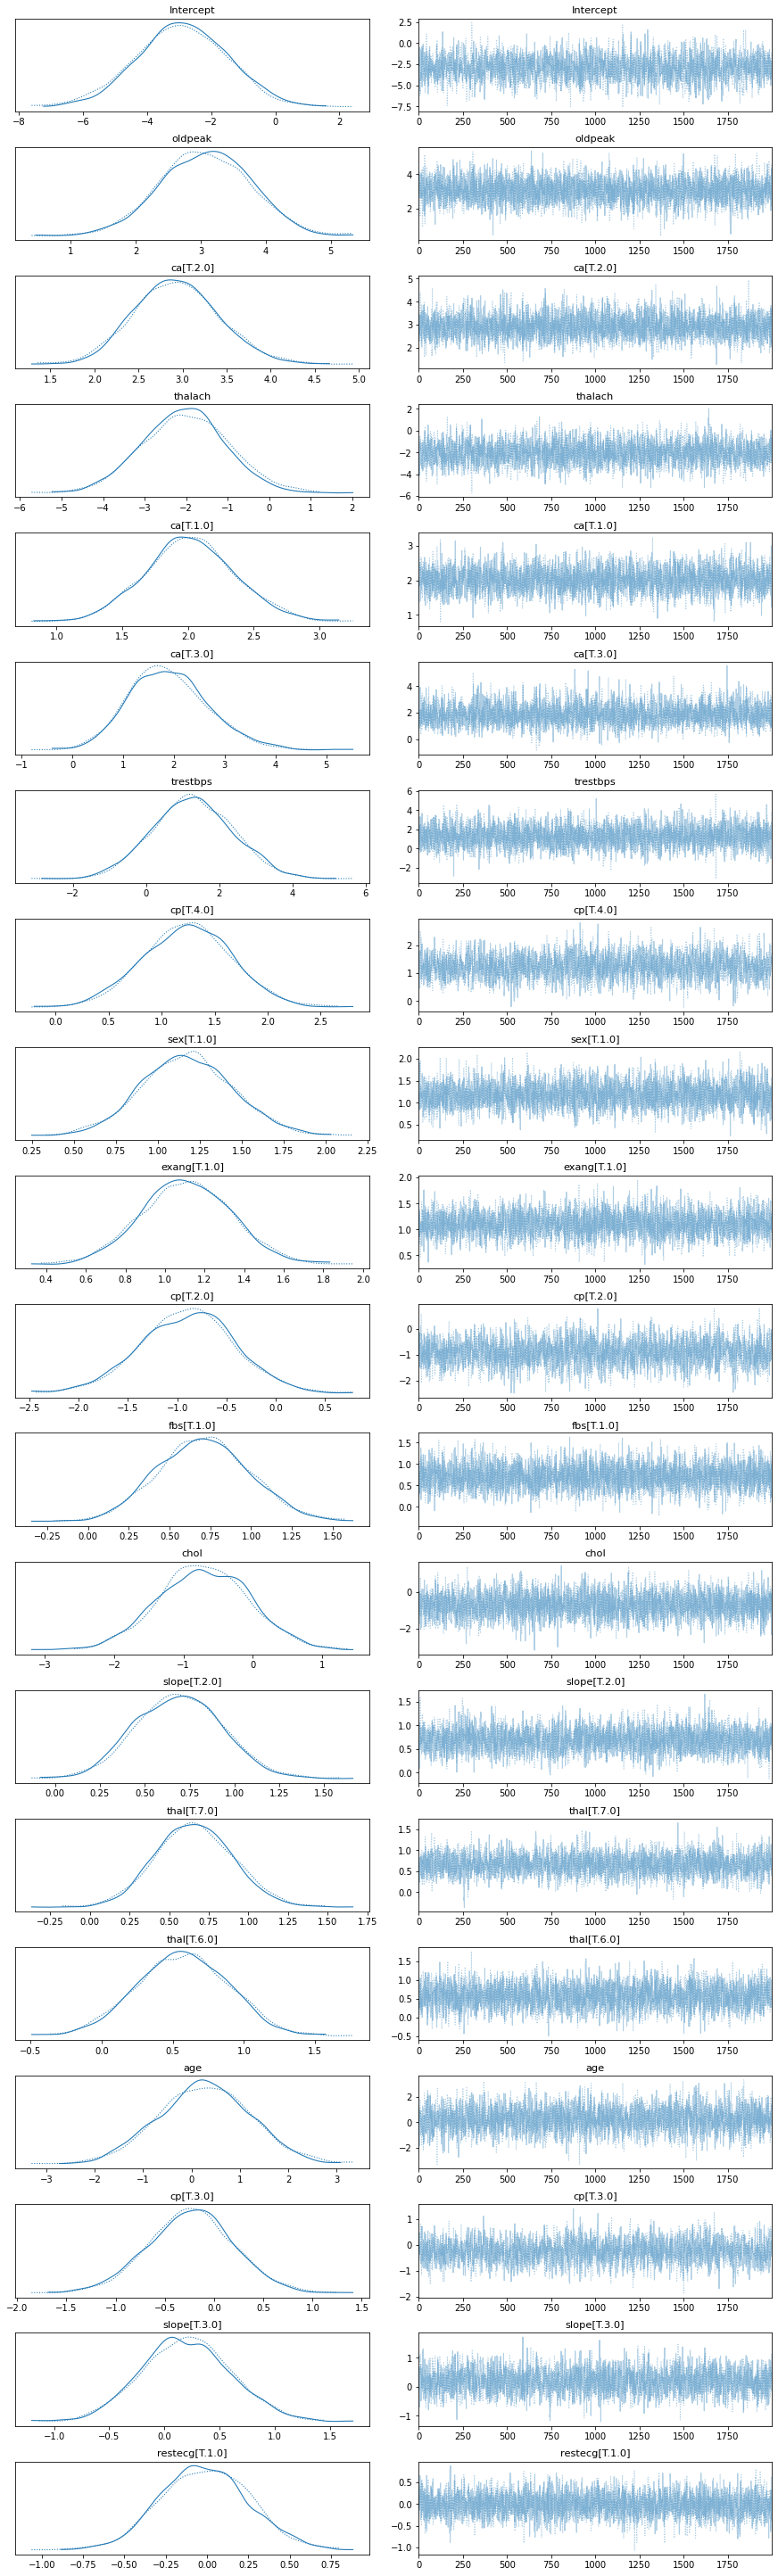

In [ ]:
axes = az.plot_trace(trace, var_names=['Intercept'] + var_order)
fig = axes.ravel()[0].figure
fig.savefig("logistic_model_trace_full.png")

In [ ]:
f = open("logistic_model_trace_summary.tex", "w")
f.write(pm.summary(trace).sort_values(by=['mean'], ascending=False, key=lambda x: abs(x)).to_latex())
f.close()
pm.summary(trace).sort_values(by=['mean'], ascending=False, key=lambda x: abs(x))

mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
oldpeak         3.069  0.694   1.756  ...    3453.0    2539.0    1.0
ca[T.2.0]       2.938  0.487   2.035  ...    3632.0    2832.0    1.0
Intercept      -2.911  1.438  -5.592  ...    1938.0    1918.0    1.0
thalach        -2.031  1.018  -3.894  ...    2569.0    2743.0    1.0
ca[T.1.0]       2.018  0.342   1.403  ...    3441.0    3047.0    1.0
ca[T.3.0]       1.903  0.795   0.487  ...    2669.0    2384.0    1.0
trestbps        1.279  1.091  -0.751  ...    3702.0    2743.0    1.0
cp[T.4.0]       1.245  0.419   0.442  ...    1988.0    2459.0    1.0
sex[T.1.0]      1.178  0.274   0.646  ...    3372.0    2562.0    1.0
exang[T.1.0]    1.110  0.228   0.684  ...    2666.0    2349.0    1.0
cp[T.2.0]      -0.897  0.476  -1.801  ...    2075.0    2560.0    1.0
fbs[T.1.0]      0.711  0.281   0.210  ...    3933.0    3028.0    1.0
chol           -0.704  0.656  -1.969  ...    3340.0    2641.0    1.0
slope[T.2.0]    0.691  0.242   0.245  ...    2901.0    2740.0    1.0
thal[T.7.0]     0.659  0.245   0.197  ...    2774.0    2388.0    1.0
thal[T.6.0]     0.570  0.320  -0.048  ...    3100.0    3029.0    1.0
age             0.268  0.967  -1.657  ...    2950.0    2451.0    1.0
cp[T.3.0]      -0.234  0.432  -1.046  ...    2068.0    2420.0    1.0
slope[T.3.0]    0.200  0.403  -0.576  ...    2561.0    2784.0    1.0
restecg[T.1.0] -0.013  0.268  -0.474  ...    3024.0    2311.0    1.0
restecg[T.2.0]  0.002  0.282  -0.515  ...    3561.0    2710.0    1.0

[21 rows x 9 columns]

In [ ]:
with logistic_model:
  ppc = pm.sample_posterior_predictive(trace, random_seed=123)

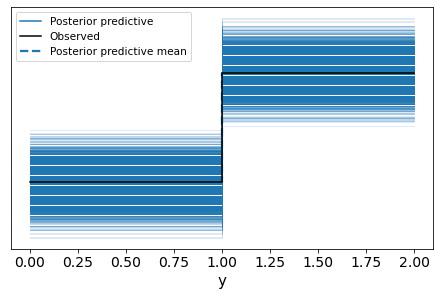

In [ ]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=logistic_model));

# Bayesian Model Averaging Logistic Regression


https://www.kaggle.com/billbasener/bayesian-model-averaging-logistic-regression

In [ ]:
df.head()
train = df.drop(['country','id'], axis=1)

In [ ]:
train.head()

age  sex   cp  trestbps  chol  ...   oldpeak slope   ca thal  target
0  0.415584  1.0  1.0     0.475   0.0  ...  0.112903   1.0  1.0  7.0     1.0
1  0.441558  1.0  4.0     0.575   0.0  ...  0.032258   1.0  1.0  3.0     1.0
2  0.454545  1.0  4.0     0.575   0.0  ...  0.000000   2.0  1.0  7.0     1.0
3  0.467532  1.0  4.0     0.550   0.0  ...  0.161290   2.0  1.0  6.0     1.0
4  0.493506  0.0  4.0     0.525   0.0  ...  0.451613   1.0  1.0  3.0     1.0

[5 rows x 14 columns]

In [ ]:
X = train.drop(["target"], axis=1)
y = train["target"]

In [ ]:
X.sample(5)

age  sex   cp  trestbps      chol  ... exang   oldpeak  slope   ca  thal
79  0.597403  1.0  2.0     0.700  0.456053  ...   1.0  0.000000    2.0  0.0   3.0
40  0.844156  0.0  4.0     0.750  0.373134  ...   0.0  0.161290    2.0  3.0   7.0
19  0.597403  1.0  4.0     0.575  0.000000  ...   1.0  0.241935    2.0  2.0   7.0
41  0.519481  1.0  4.0     0.625  0.000000  ...   0.0  0.000000    1.0  0.0   7.0
7   0.740260  0.0  4.0     0.600  0.587065  ...   1.0  0.096774    1.0  0.0   3.0

[5 rows x 13 columns]

In [ ]:
# building the model and fitting the data 
log_reg = sm.Logit(y, add_constant(X)).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.394728
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  920
Model:                          Logit   Df Residuals:                      906
Method:                           MLE   Df Model:                           13
Date:                Wed, 11 Aug 2021   Pseudo R-squ.:                  0.4258
Time:                        23:17:35   Log-Likelihood:                -363.15
converged:                       True   LL-Null:                       -632.47
Covariance Type:            nonrobust   LLR p-value:                8.987e-107
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7944      1.380     -3.473      0.001      -7.500      -2.089
age            0.1689      0.897      0.188      0.851      -1.589       1.926
sex            1.1096      0.256      4.337      0.000       0.608       1.611
cp             0.7241      0.105      6.896      0.000       0.518       0.930
trestbps       1.0633      1.041      1.022      0.307      -0.976       3.103
chol          -0.6771      0.603     -1.122      0.262      -1.859       0.505
fbs            0.5516      0.266      2.071      0.038       0.030       1.074
restecg       -0.0003      0.124     -0.002      0.998      -0.243       0.242
thalach       -2.2712      0.926     -2.452      0.014      -4.087      -0.456
exang          1.1168      0.215      5.194      0.000       0.695       1.538
oldpeak        3.0286      0.649      4.665      0.000       1.756       4.301
slope          0.2868      0.180      1.596      0.110      -0.065       0.639
ca             1.3421      0.189      7.104      0.000       0.972       1.712
thal           0.1561      0.058      2.672      0.008       0.042       0.271
==============================================================================
"""

In [ ]:
results_summary = log_reg.summary()
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_as_html = results_summary.tables[1].as_html()
outframe = pd.read_html(results_as_html, header=0, index_col=0)[0]

f = open("sm_Logit_summary.tex", "w")
f.write(outframe.sort_values(by=['coef'], ascending=False, key=lambda x: abs(x)).to_latex())
f.close()

Bayesian Model Averaging

In [ ]:
class BMA:
    
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,1)
        self.coefficients = np.zeros(self.nCols)
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_next = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
            if num_elements == 1:
                Models_current = Models_next
                Models_previous = []
            else:
                idx_keep = np.zeros(len(Models_next))
                for M_new,idx in zip(Models_next,range(len(Models_next))):
                    for M_good in Models_previous:
                        if(all(x in M_new for x in M_good)):
                            idx_keep[idx] = 1
                            break
                        else:
                            pass
                Models_current = np.asarray(Models_next)[np.where(idx_keep==1)].tolist()
                Models_previous = []
                        
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]
                if self.RegType == 'Logit':
                    model_regr = sm.Logit(self.y, model_X.astype(float)).fit(disp=0)
                else:
                    model_regr = OLS(self.y, model_X).fit()
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                    
                if (model_likelihood > max_likelihood/20):
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                    self.likelihoods_all[str(model_index_set)] = model_likelihood
                    
                    # Add this likelihood to the running tally of likelihoods.
                    likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)

                    # Add this likelihood (times the priors) to the running tally
                    # of likelihoods for each variable in the model.
                    for idx, i in zip(model_index_set, range(num_elements)):
                        self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=1000)
                        self.coefficients_mp[idx] = mp.fadd(self.coefficients_mp[idx], model_regr.params[i]*model_likelihood, prec=1000)
                    Models_previous.append(model_index_set) # add this model to the list of good models
                    max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                else:
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"rejected by Occam's window")
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            self.coefficients[idx] = mp.fdiv(self.coefficients_mp[idx],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
    def predict(self, data):
        data = np.asarray(data)
        if self.RegType == 'Logit':
            try:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data)))
            except:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data.T)))
        else:
            try:
                result = np.dot(self.coefficients,data)
            except:
                result = np.dot(self.coefficients,data.T)
        
        return result  
        
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df 

In [ ]:
result = BMA(y,add_constant(X), RegType = 'Logit', Verbose=True).fit()

Computing BMA for models of size:  1
Model Variables: (0,) likelihood= 6.9445631083223014952389595640255329126311686696634e-277
Model Variables: (1,) likelihood= 2.0283700135162851314246927586352238132806242029928e-274
Model Variables: (2,) likelihood= 5.3558665236033992463666973022140881259598588554269e-268
Model Variables: (3,) likelihood= 2.4920278447593166786584940113757468458851428728385e-268
Model Variables: (4,) rejected by Occam's window
Model Variables: (5,) rejected by Occam's window
Model Variables: (6,) rejected by Occam's window
Model Variables: (7,) rejected by Occam's window
Model Variables: (8,) rejected by Occam's window
Model Variables: (9,) likelihood= 3.6251852451888667423494720929257726096867847836785e-243
Model Variables: (10,) rejected by Occam's window
Model Variables: (11,) rejected by Occam's window
Model Variables: (12,) rejected by Occam's window
Model Variables: (13,) rejected by Occam's window
Computing BMA for models of size:  2
Model Variables: [0, 1] re

In [ ]:
f = open("BMA_Logit_summary.tex", "w")
f.write(result.summary().sort_values(by=['Probability'], ascending=False).to_latex())
f.close()
result.summary().sort_values(by=['Probability'], ascending=False)

Variable Name Probability Avg. Coefficient
3             cp           1         0.709164
12            ca           1          1.36365
10       oldpeak           1          3.35622
2            sex    0.999998          1.21728
9          exang    0.999995           1.1303
8        thalach    0.924357           -3.031
0          const    0.918035         -3.15797
13          thal    0.683891         0.120862
6            fbs    0.373102         0.232027
11         slope    0.169034        0.0622446
5           chol   0.0362714       -0.0297071
4       trestbps    0.025566        0.0308854
1            age   0.0209625        0.0181078
7        restecg           0                0

In [ ]:
result.likelihoods_all

{'(0,)': mpf('6.9445631083223014952389595640255329126311686696634376e-277'),
 '(1,)': mpf('2.0283700135162851314246927586352238132806242029927799e-274'),
 '(2,)': mpf('5.3558665236033992463666973022140881259598588554268608e-268'),
 '(3,)': mpf('2.4920278447593166786584940113757468458851428728384605e-268'),
 '(9,)': mpf('3.6251852451888667423494720929257726096867847836785247e-243'),
 '[0, 1, 2, 3, 8, 9, 10, 12, 13]': mpf('5.5734578054858188537203626474491727915378802228447159e-174'),
 '[0, 1, 2, 3, 8, 9, 10, 12]': mpf('2.0618996934529069408423349720768578634715333854123211e-174'),
 '[0, 2, 3, 4, 8, 9, 10, 12, 13]': mpf('6.743781818372075001832879295356128538471288111680556e-174'),
 '[0, 2, 3, 4, 8, 9, 10, 12]': mpf('2.568355300087624783261220431227230930704448626685005e-174'),
 '[0, 2, 3, 5, 8, 9, 10, 12, 13]': mpf('5.926151139519374363623864738003630373416420560483013e-174'),
 '[0, 2, 3, 5, 8, 9, 10, 12]': mpf('2.7919478216090314163747825098444049631778015342014874e-174'),
 '[0, 2, 3, 

In [ ]:
# predict the y-values from training input data
pred_BMA = result.predict(add_constant(X))
pred_Logit = log_reg.predict(add_constant(X))

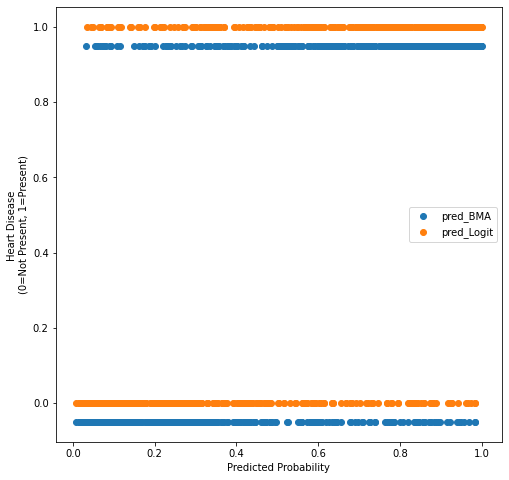

In [ ]:
# plot the predictions with the actual values
plt.figure(figsize=(8,8))
plt.scatter(pred_BMA,y.astype(int)-0.05)
plt.scatter(pred_Logit,y)
plt.xlabel("Predicted Probability")
plt.ylabel("Heart Disease \n(0=Not Present, 1=Present)")
plt.legend(['pred_BMA','pred_Logit'])
plt.show();

In [ ]:
# compute accuracy
print("BMA Accuracy: ", np.sum((pred_BMA > 0.5) == y)/len(y))
print("Logit Accuracy: ", np.sum((pred_Logit > 0.5) == y)/len(y))

BMA Accuracy:  0.8391304347826087
Logit Accuracy:  0.8336956521739131


# Hierarchical Model - Non-Informative

https://docs.pymc.io/notebooks/GLM-hierarchical.html

In [ ]:
df.head()

country       age  sex   cp  trestbps  ...  slope   ca thal  target id
0  switzerland  0.415584  1.0  1.0     0.475  ...    1.0  1.0  7.0     1.0  0
1  switzerland  0.441558  1.0  4.0     0.575  ...    1.0  1.0  3.0     1.0  0
2  switzerland  0.454545  1.0  4.0     0.575  ...    2.0  1.0  7.0     1.0  0
3  switzerland  0.467532  1.0  4.0     0.550  ...    2.0  1.0  6.0     1.0  0
4  switzerland  0.493506  0.0  4.0     0.525  ...    1.0  1.0  3.0     1.0  0

[5 rows x 16 columns]

In [ ]:
n = df.shape[0]
id_country = df.id.unique()
countries = len(id_country)

age	= df.age.values
sex	= df.sex.values
cp	= df.cp.values
trestbps	= df.trestbps.values
chol	= df.chol.values
fbs	= df.fbs.values
restecg	= df.restecg.values
thalach	= df.thalach.values
exang	= df.exang.values
oldpeak	= df.oldpeak.values
slope	= df.slope.values
ca	= df.ca.values
thal	= df.thal.values
target	= df.target
country_ids = df.id.values

In [ ]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    # a
    mu_a = pm.Normal("mu_intercept", mu=0.0, sigma=100)
    sigma_a = pm.HalfCauchy("sigma_a", 5.0)

    #b
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfCauchy("sigma_b", 5.0)

    #c
    mu_c = pm.Normal("mu_c", mu=0.0, sigma=100)
    sigma_c = pm.HalfCauchy("sigma_c", 5.0)

    #d
    mu_d = pm.Normal("mu_d", mu=0.0, sigma=100)
    sigma_d = pm.HalfCauchy("sigma_d", 5.0)

    #e
    mu_e = pm.Normal("mu_e", mu=0.0, sigma=100)
    sigma_e = pm.HalfCauchy("sigma_e", 5.0)

    #f
    mu_f = pm.Normal("mu_f", mu=0.0, sigma=100)
    sigma_f = pm.HalfCauchy("sigma_f", 5.0)

    #g
    mu_g = pm.Normal("mu_g", mu=0.0, sigma=100)
    sigma_g = pm.HalfCauchy("sigma_g", 5.0)

    #h
    mu_h = pm.Normal("mu_h", mu=0.0, sigma=100)
    sigma_h = pm.HalfCauchy("sigma_h", 5.0)

    #i
    mu_i = pm.Normal("mu_i", mu=0.0, sigma=100)
    sigma_i = pm.HalfCauchy("sigma_i", 5.0)

    #j
    mu_j = pm.Normal("mu_j", mu=0.0, sigma=100)
    sigma_j = pm.HalfCauchy("sigma_j", 5.0)

    #k
    mu_k = pm.Normal("mu_k", mu=0.0, sigma=100)
    sigma_k = pm.HalfCauchy("sigma_k", 5.0)

        #l
    mu_l = pm.Normal("mu_l", mu=0.0, sigma=100)
    sigma_l = pm.HalfCauchy("sigma_l", 5.0)

        #m
    mu_m = pm.Normal("mu_m", mu=0.0, sigma=100)
    sigma_m = pm.HalfCauchy("sigma_m", 5.0)

        #o
    mu_o = pm.Normal("mu_o", mu=0.0, sigma=100)
    sigma_o = pm.HalfCauchy("sigma_o", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).

    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=countries)
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=countries)
    c = pm.Normal("c", mu=mu_c, sigma=sigma_c, shape=countries)
    d = pm.Normal("d", mu=mu_d, sigma=sigma_d, shape=countries)
    e = pm.Normal("e", mu=mu_d, sigma=sigma_e, shape=countries)
    f = pm.Normal("f", mu=mu_e, sigma=sigma_f, shape=countries)
    g = pm.Normal("g", mu=mu_f, sigma=sigma_g, shape=countries)
    h = pm.Normal("h", mu=mu_g, sigma=sigma_h, shape=countries)
    i = pm.Normal("i", mu=mu_h, sigma=sigma_i, shape=countries)
    j = pm.Normal("j", mu=mu_i, sigma=sigma_j, shape=countries)
    k = pm.Normal("k", mu=mu_j, sigma=sigma_k, shape=countries)
    l = pm.Normal("l", mu=mu_k, sigma=sigma_l, shape=countries)
    m = pm.Normal("m", mu=mu_m, sigma=sigma_m, shape=countries)
    o = pm.Normal("o", mu=mu_o, sigma=sigma_o, shape=countries)


    # Residual Error
    sigma_y = HalfCauchy('sigma_y', 5)

    y_hat = a[country_ids] + b[country_ids] * cp +\
            c[country_ids]*ca + d[country_ids]*oldpeak +\
            e[country_ids]*sex + f[country_ids]*exang +\
            g[country_ids]*thalach + h[country_ids]*thal +\
            i[country_ids]*fbs + j[country_ids]*slope +\
            k[country_ids]*chol + l[country_ids]*trestbps +\
            m[country_ids]*age + o[country_ids]*restecg

    # Data likelihood Normal
    #y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=target)

    # Data likelihood Bernoulli
    y_like = pm.Bernoulli("y_like", p=(1.0/(1+T.exp(-y_hat))),observed=target) 

In [ ]:
pass
print("Not Executing Non-Informative Prior")
#with hierarchical_model:
#    hierarchical_trace = pm.sample(1000, tune=2000, target_accept=0.9)

Not Executing Non-Informative Prior


In [ ]:
#pm.traceplot(hierarchical_trace);

In [ ]:
#pm.summary(hierarchical_trace).head(14).sort_values(by=['mean'], ascending=False, key=lambda x: abs(x))

In [ ]:
#with hierarchical_model:
#  ppc_hier = pm.sample_posterior_predictive(hierarchical_trace, random_seed=123)

https://docs.pymc.io/notebooks/posterior_predictive.html

In [ ]:
#az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_hier, model=hierarchical_model));

In [ ]:
"""
fig, axis = plt.subplots(1, 4, figsize=(12, 6), sharey=True, sharex=True)

for i in [0,1,2,3]:
    xvals = np.linspace(-0.2, 1.2, 20)
    z = list(df['id'].unique())[i]
    subset = df[df['id'] == z]

    for a,b,c,d,e,f,g,h,ii,j,k,l,m,o  in zip(
                            hierarchical_trace["a"][z], 
                            hierarchical_trace["b"][z],
                            hierarchical_trace["c"][z],
                            hierarchical_trace["d"][z],
                            hierarchical_trace["e"][z],
                            hierarchical_trace["f"][z],
                            hierarchical_trace["g"][z],
                            hierarchical_trace["h"][z],
                            hierarchical_trace["i"][z],
                            hierarchical_trace["j"][z],
                            hierarchical_trace["k"][z],
                            hierarchical_trace["l"][z],
                            hierarchical_trace["m"][z],
                            hierarchical_trace["o"][z]):

        axis[i].plot(xvals, 
                      a + (b * xvals) + (c * xvals) + (d * xvals) +\
                     (e * xvals) +\
                     (f * xvals) +\
                     (g * xvals) +\
                     (h * xvals) +\
                     (ii * xvals) +\
                     (j * xvals) +\
                     (k * xvals) +\
                     (l * xvals) +\
                     (m * xvals) +\
                     (o * xvals)  , "g", alpha=0.1)
    axis[i].plot(xvals,
                 hierarchical_trace["a"][z].mean() +\
                 hierarchical_trace["b"][z].mean() * xvals +\
                 hierarchical_trace["c"][z].mean() * xvals +\
                 hierarchical_trace["d"][z].mean() * xvals +\
                 hierarchical_trace["e"][z].mean() * xvals +\
                 hierarchical_trace["f"][z].mean() * xvals +\
                 hierarchical_trace["g"][z].mean() * xvals +\
                 hierarchical_trace["h"][z].mean() * xvals +\
                 hierarchical_trace["i"][z].mean() * xvals +\
                 hierarchical_trace["j"][z].mean() * xvals +\
                 hierarchical_trace["k"][z].mean() * xvals +\
                 hierarchical_trace["l"][z].mean() * xvals +\
                 hierarchical_trace["m"][z].mean() * xvals +\
                 hierarchical_trace["o"][z].mean() * xvals , 
            alpha=1,
            lw=2.0,
            label="hierarchical",
        )
    #x = np.array(subset['food']) + (np.random.randn(len(subset))*0.01)
    #y = np.array(subset['sales'])
    #axis[i].scatter(x ,y ,
    #    alpha=1,
    #    color="k",
    #    marker=".",
    #    s=80,
    #    label="original data",
    #)
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(["0", "1"])
    #axis[i].set_ylim(-1, 2)
    axis[i].set_title("Country ID: {}".format(z))
    if not i % 4:
        axis[i].legend()
        axis[i].set_ylabel("y_hat")
"""
pass

# Hierarchical Model - Deterministic

In [ ]:
df.head()

country       age  sex   cp  trestbps  ...  slope   ca thal  target id
0  switzerland  0.415584  1.0  1.0     0.475  ...    1.0  1.0  7.0     1.0  0
1  switzerland  0.441558  1.0  4.0     0.575  ...    1.0  1.0  3.0     1.0  0
2  switzerland  0.454545  1.0  4.0     0.575  ...    2.0  1.0  7.0     1.0  0
3  switzerland  0.467532  1.0  4.0     0.550  ...    2.0  1.0  6.0     1.0  0
4  switzerland  0.493506  0.0  4.0     0.525  ...    1.0  1.0  3.0     1.0  0

[5 rows x 16 columns]

In [ ]:
n = df.shape[0]
id_country = df.id.unique()
countries = len(id_country)

age	= df.age.values
sex	= df.sex.values
cp	= df.cp.values
trestbps	= df.trestbps.values
chol	= df.chol.values
fbs	= df.fbs.values
restecg	= df.restecg.values
thalach	= df.thalach.values
exang	= df.exang.values
oldpeak	= df.oldpeak.values
slope	= df.slope.values
ca	= df.ca.values
thal	= df.thal.values
target	= df.target
country_ids = df.id.values

In [ ]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    # intercept
    mu_a = pm.Normal("mu_intercept", mu=0.0, sigma=100)
    sigma_a = pm.HalfCauchy("sigma_intercept", 5.0)

    #cp
    mu_b = pm.Normal("mu_cp", mu=0.0, sigma=100)
    sigma_b = pm.HalfCauchy("sigma_cp", 5.0)

    # ca
    mu_c = pm.Normal("mu_ca", mu=0.0, sigma=100)
    sigma_c = pm.HalfCauchy("sigma_ca", 5.0)

    # oldpeak
    mu_d = pm.Normal("mu_oldpeak", mu=0.0, sigma=100)
    sigma_d = pm.HalfCauchy("sigma_oldpeak", 5.0)

    # sex
    mu_e = pm.Normal("mu_sex", mu=0.0, sigma=100)
    sigma_e = pm.HalfCauchy("sigma_sex", 5.0)

    # exang
    mu_f = pm.Normal("mu_exang", mu=0.0, sigma=100)
    sigma_f = pm.HalfCauchy("sigma_exang", 5.0)

    #thalach
    mu_g = pm.Normal("mu_thalach", mu=0.0, sigma=100)
    sigma_g = pm.HalfCauchy("sigma_thalach", 5.0)

    # thal
    mu_h = pm.Normal("mu_thal", mu=0.0, sigma=100)
    sigma_h = pm.HalfCauchy("sigma_thal", 5.0)

    # fbs
    mu_i = pm.Normal("mu_fbs", mu=0.0, sigma=100)
    sigma_i = pm.HalfCauchy("sigma_fbs", 5.0)

    # slope
    mu_j = pm.Normal("mu_slope", mu=0.0, sigma=100)
    sigma_j = pm.HalfCauchy("sigma_slope", 5.0)

    # chol
    mu_k = pm.Normal("mu_chol", mu=0.0, sigma=100)
    sigma_k = pm.HalfCauchy("sigma_chol", 5.0)

    # trestbps
    mu_l = pm.Normal("mu_trestbps", mu=0.0, sigma=100)
    sigma_l = pm.HalfCauchy("sigma_trestbps", 5.0)

    # age
    mu_m = pm.Normal("mu_age", mu=0.0, sigma=100)
    sigma_m = pm.HalfCauchy("sigma_age", 5.0)

    # restecg
    mu_o = pm.Normal("mu_restecg", mu=0.0, sigma=100)
    sigma_o = pm.HalfCauchy("sigma_restecg", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).

    # intercept
    a_offset = Normal('intercept_offset', mu=0, sd=1, shape=countries)
    a = Deterministic("intercept", mu_a + a_offset * sigma_a)

    # cp   
    b_offset = Normal('cp_offset', mu=0, sd=1, shape=countries)
    b = Deterministic("cp", mu_b + b_offset * sigma_b)

    # ca
    c_offset = Normal('ca_offset', mu=0, sd=1, shape=countries)
    c = Deterministic("ca", mu_c + c_offset * sigma_c)

    # oldpeak
    d_offset = Normal('oldpeak_offset', mu=0, sd=1, shape=countries)
    d = Deterministic("oldpeak", mu_d + d_offset * sigma_d)

    # sex
    e_offset = Normal('sex_offset', mu=0, sd=1, shape=countries)
    e = Deterministic("sex", mu_e + e_offset * sigma_e)

    # exang
    f_offset = Normal('exang_offset', mu=0, sd=1, shape=countries)
    f = Deterministic("exang", mu_f + f_offset * sigma_f)

    # thalach
    g_offset = Normal('thalach_offset', mu=0, sd=1, shape=countries)
    g = Deterministic("thalach", mu_g + g_offset * sigma_g)

    # thal
    h_offset = Normal('thal_offset', mu=0, sd=1, shape=countries)
    h = Deterministic("thal", mu_h + h_offset * sigma_h)

    # fbs
    i_offset = Normal('fbs_offset', mu=0, sd=1, shape=countries)
    i = Deterministic("fbs", mu_i + i_offset * sigma_i)

    # slope
    j_offset = Normal('slope_offset', mu=0, sd=1, shape=countries)
    j = Deterministic("slope", mu_j + j_offset * sigma_j)

    # chol
    k_offset = Normal('chol_offset', mu=0, sd=1, shape=countries)
    k = Deterministic("chol", mu_k + k_offset * sigma_k)

    # trestbps
    l_offset = Normal('trestbps_offset', mu=0, sd=1, shape=countries)
    l = Deterministic("trestbps", mu_l + l_offset * sigma_l)

    # age
    m_offset = Normal('age_offset', mu=0, sd=1, shape=countries)
    m = Deterministic("age", mu_m + m_offset * sigma_m)

    # restecg
    o_offset = Normal('restecg_offset', mu=0, sd=1, shape=countries)
    o = Deterministic("restecg", mu_o + o_offset * sigma_o)

    # Residual Error
    sigma_y = HalfCauchy('sigma_y', 5)

    y_hat = a[country_ids] + b[country_ids] * cp +\
            c[country_ids]*ca + d[country_ids]*oldpeak +\
            e[country_ids]*sex + f[country_ids]*exang +\
            g[country_ids]*thalach + h[country_ids]*thal +\
            i[country_ids]*fbs + j[country_ids]*slope +\
            k[country_ids]*chol + l[country_ids]*trestbps +\
            m[country_ids]*age + o[country_ids]*restecg

    # Data likelihood Normal
    #y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=target)

    # Data likelihood Bernoulli
    # These Are equal: https://docs.pymc.io/api/math.html#pymc3.math.invlogit
    #y_like = pm.Bernoulli("y_like", p=(1.0/(1+T.exp(-y_hat))),observed=target)
    y_like = pm.Bernoulli("y_like", p=pm.math.invlogit(y_hat),observed=target)

    

In [ ]:
with hierarchical_model:
    #hierarchical_trace = pm.sample(10, tune=20, target_accept=0.9)
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_y, restecg_offset, age_offset, trestbps_offset, chol_offset, slope_offset, fbs_offset, thal_offset, thalach_offset, exang_offset, sex_offset, oldpeak_offset, ca_offset, cp_offset, intercept_offset, sigma_restecg, mu_restecg, sigma_age, mu_age, sigma_trestbps, mu_trestbps, sigma_chol, mu_chol, sigma_slope, mu_slope, sigma_fbs, mu_fbs, sigma_thal, mu_thal, sigma_thalach, mu_thalach, sigma_exang, mu_exang, sigma_sex, mu_sex, sigma_oldpeak, mu_oldpeak, sigma_ca, mu_ca, sigma_cp, mu_cp, sigma_intercept, mu_intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 2363 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
MUs = [x for x in hierarchical_trace.varnames if 'mu' in x]
OFFSETs = [x for x in hierarchical_trace.varnames if 'offset' in x]
SIGMAs = [x for x in hierarchical_trace.varnames if ('sigma_' in x) and ('log' not in x) ]
OTHERs = [x for x in hierarchical_trace.varnames 
          if ('sigma_' not in x) and ('log' not in x) and ('mu' not in x) and ('offset' not in x)]

In [ ]:
df_tmp = pm.summary(hierarchical_trace, var_names=MUs)
var_order = [ row for row in df_tmp.sort_values(by=['mean'], ascending=False, key=lambda x: abs(x)).index]
var_order.remove('mu_intercept')

In [ ]:
f = open("hierarchical_trace_mu_summary.tex", "w")
f.write(pm.summary(hierarchical_trace, var_names=MUs).sort_values(by=['mean'], ascending=False, key=lambda x: abs(x)).to_latex())
f.close()
pm.summary(hierarchical_trace, var_names=MUs).sort_values(by=['mean'], ascending=False, key=lambda x: abs(x))

mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
mu_intercept -6.019  2.458 -10.150   -0.902  ...    0.077    1761.0    1055.0    1.0
mu_oldpeak    2.988  2.099  -1.117    6.780  ...    0.038    1638.0     804.0    1.0
mu_thalach   -1.797  1.659  -4.632    1.430  ...    0.028    2271.0    1941.0    1.0
mu_ca         1.437  2.309  -3.338    6.192  ...    0.056    1603.0    1300.0    1.0
mu_trestbps   1.427  1.932  -2.439    4.888  ...    0.039    2190.0    1714.0    1.0
mu_chol       1.144  2.415  -2.753    5.736  ...    0.063    1711.0    1235.0    1.0
mu_exang      1.109  0.467   0.285    1.941  ...    0.013    1501.0     666.0    1.0
mu_sex        0.980  0.787  -0.613    2.328  ...    0.015    1908.0    1419.0    1.0
mu_age        0.838  1.745  -2.477    4.199  ...    0.030    2163.0    1562.0    1.0
mu_cp         0.743  0.195   0.405    1.108  ...    0.003    2564.0    1755.0    1.0
mu_fbs        0.743  1.545  -1.229    3.871  ...    0.043    1586.0    1531.0    1.0
mu_slope      0.391  0.763  -0.861    1.857  ...    0.027     906.0     786.0    1.0
mu_restecg   -0.135  0.536  -1.005    0.737  ...    0.024    1051.0     678.0    1.0
mu_thal       0.126  0.234  -0.376    0.560  ...    0.005    1479.0    1273.0    1.0

[14 rows x 9 columns]

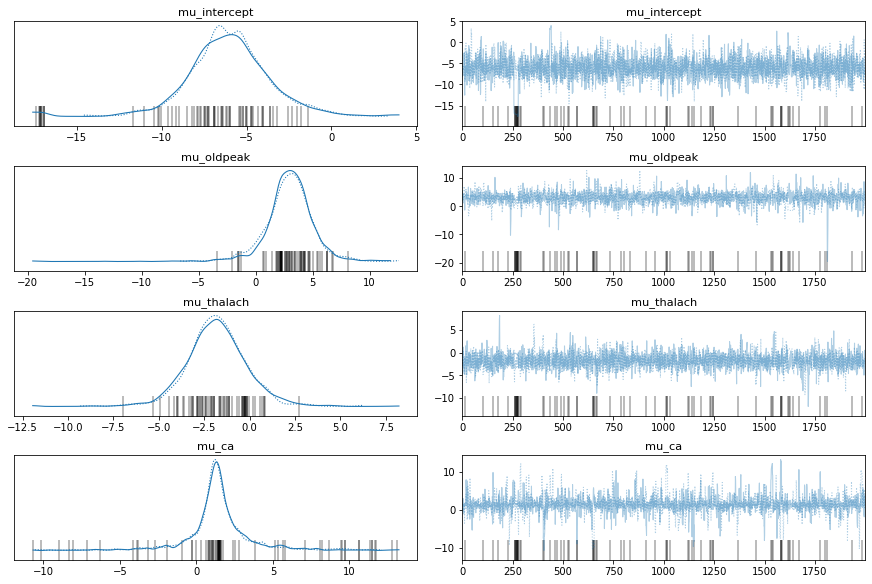

In [ ]:
axes = pm.traceplot(hierarchical_trace, var_names=['mu_intercept'] + var_order[0:3]);
fig = axes.ravel()[0].figure
fig.savefig("hierarchical_trace_subset_mu.png")

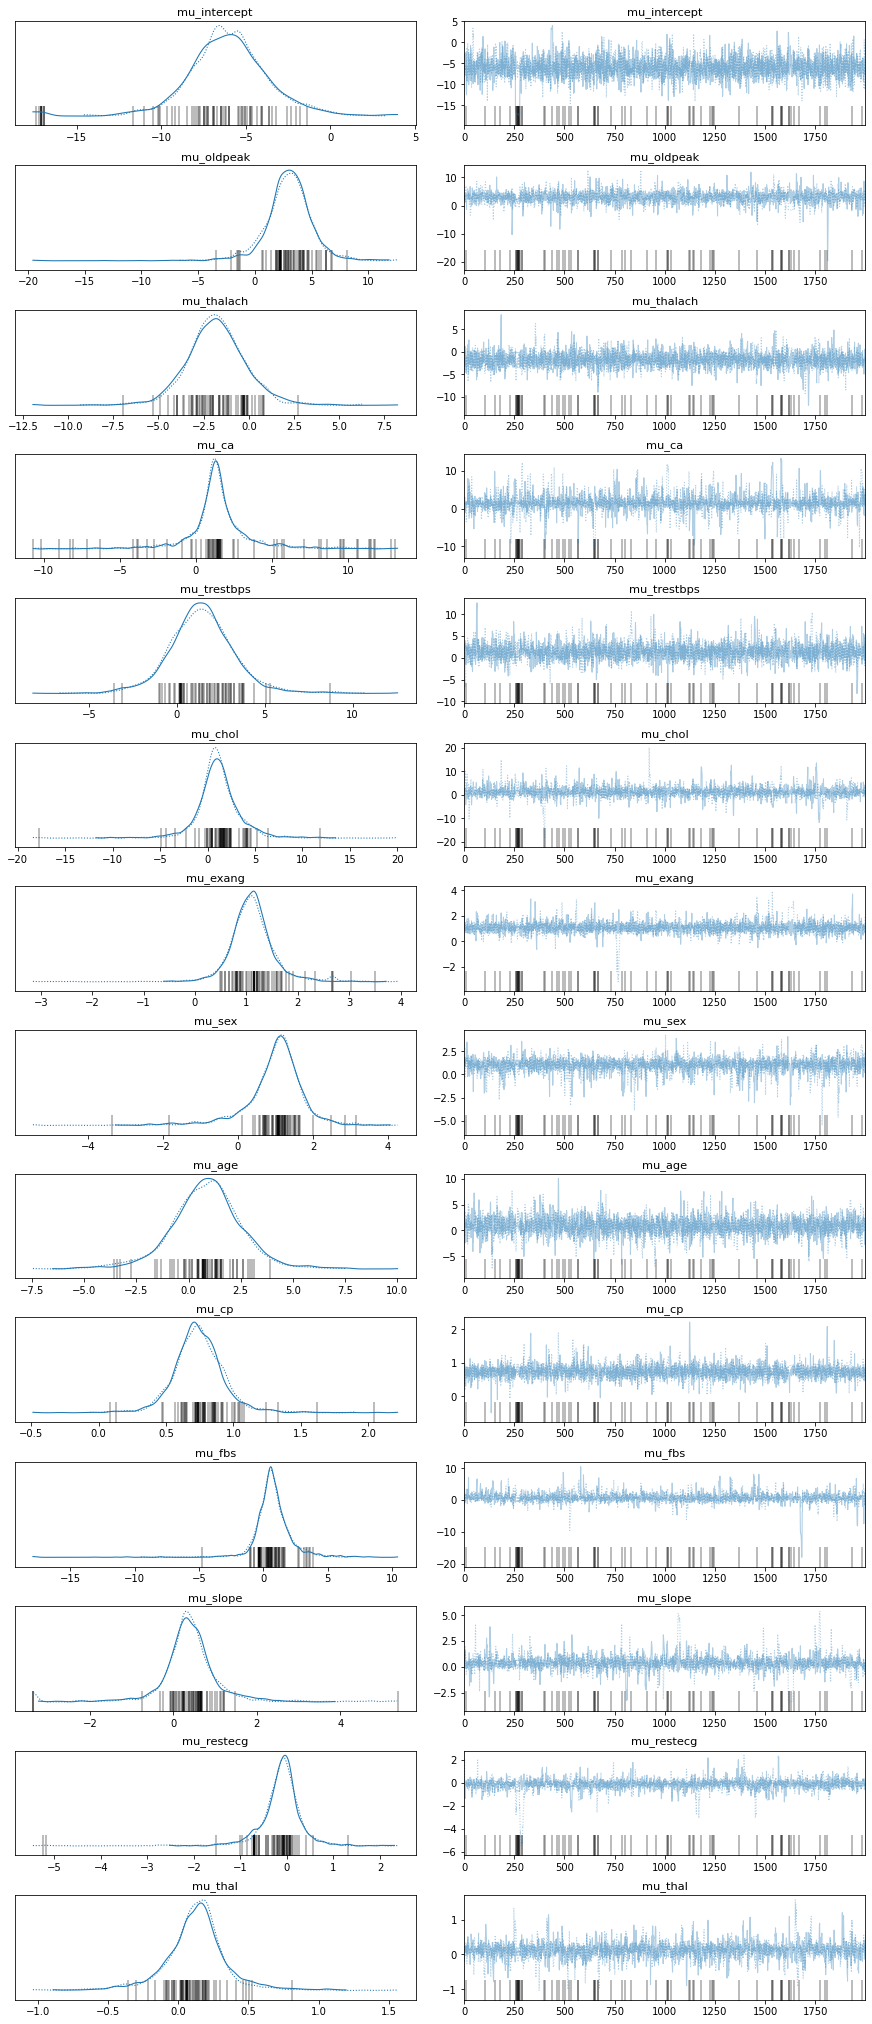

In [ ]:
axes = pm.traceplot(hierarchical_trace, var_names=['mu_intercept'] + var_order);
fig = axes.ravel()[0].figure
fig.savefig("hierarchical_trace_full_mu.png")

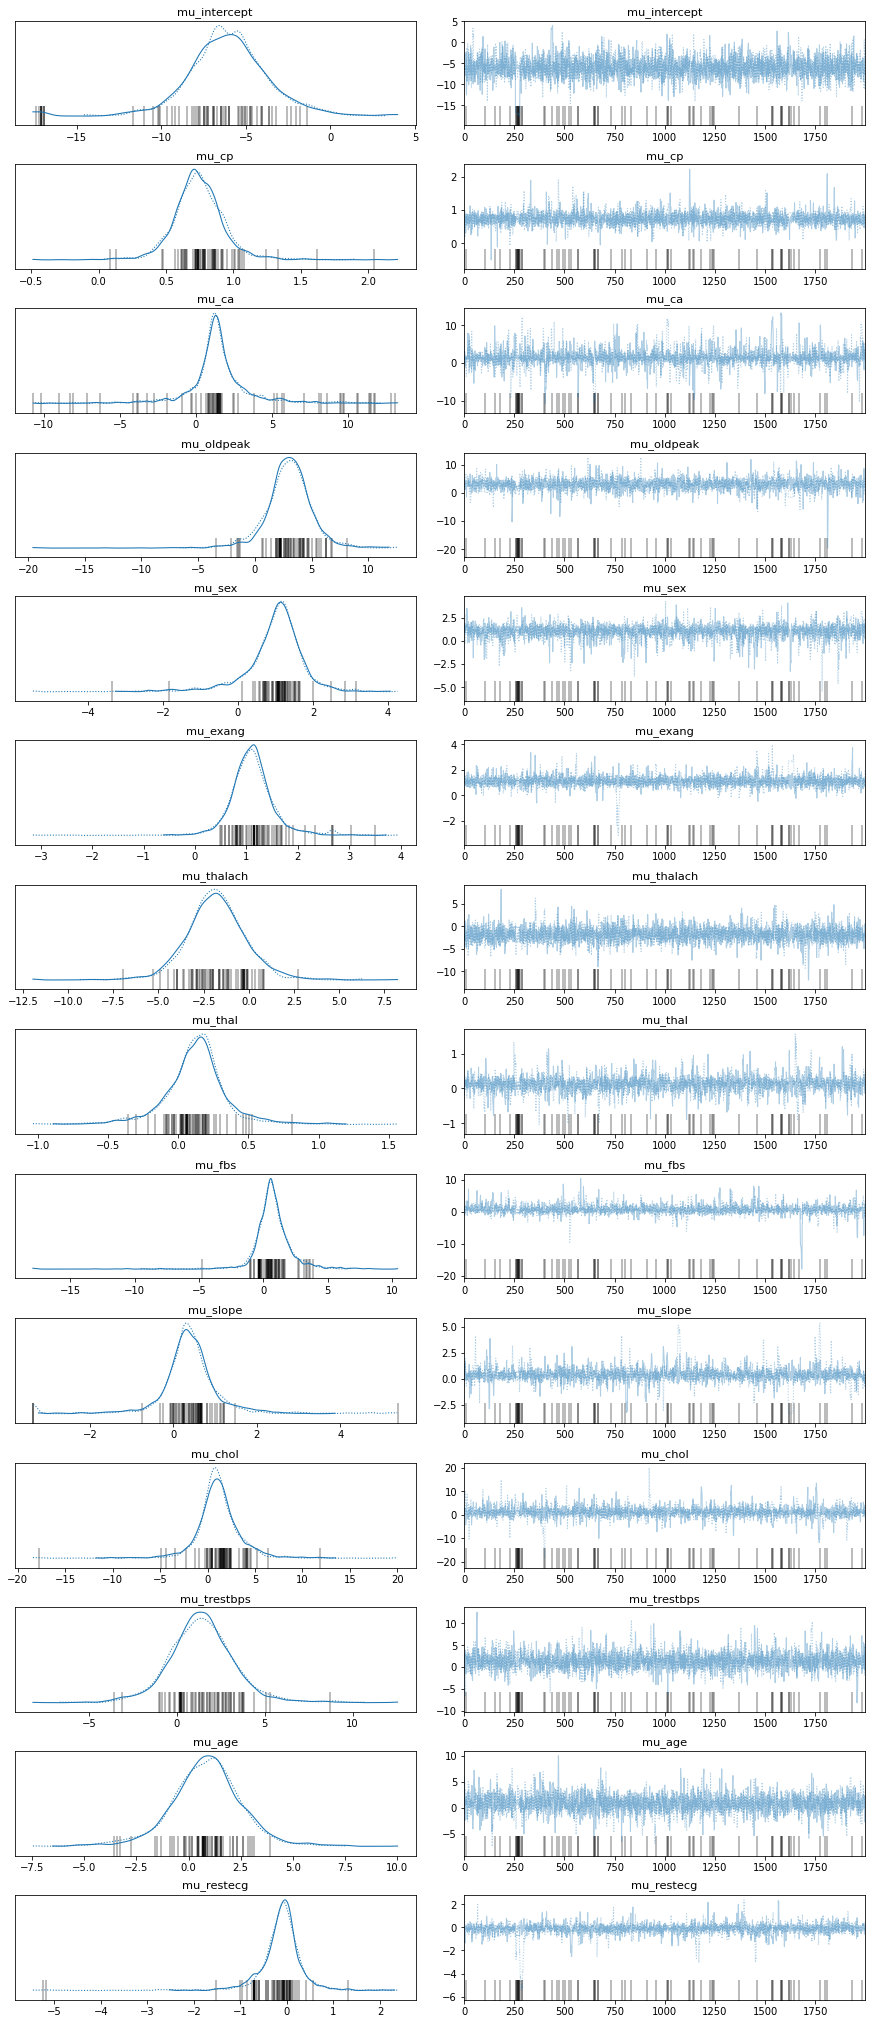

In [ ]:
pm.traceplot(hierarchical_trace, var_names=MUs);

### Offset Plots

In [ ]:
f = open("hierarchical_trace_offset_summary.tex", "w")
f.write(pm.summary(hierarchical_trace, var_names=OFFSETs).to_latex())
f.close()
pm.summary(hierarchical_trace, var_names=OFFSETs)

mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
intercept_offset[0]  0.703  0.892  -0.982  ...    1791.0     972.0    1.0
intercept_offset[1] -0.428  0.808  -1.970  ...    3211.0    2621.0    1.0
intercept_offset[2] -0.045  0.812  -1.580  ...    3108.0    2901.0    1.0
intercept_offset[3] -0.238  0.792  -1.765  ...    3299.0    2569.0    1.0
cp_offset[0]         0.149  0.916  -1.615  ...    5040.0    2491.0    1.0
cp_offset[1]        -0.189  0.836  -1.809  ...    3560.0    2132.0    1.0
cp_offset[2]        -0.042  0.855  -1.640  ...    3730.0    1471.0    1.0
cp_offset[3]         0.123  0.843  -1.501  ...    2923.0    1109.0    1.0
ca_offset[0]         0.134  0.823  -1.440  ...    2790.0    3141.0    1.0
ca_offset[1]        -0.117  0.800  -1.539  ...    3030.0    2676.0    1.0
ca_offset[2]         0.011  0.986  -1.816  ...    4548.0    2650.0    1.0
ca_offset[3]         0.002  0.993  -1.832  ...    4544.0    1880.0    1.0
oldpeak_offset[0]   -0.563  0.764  -1.993  ...    2899.0    2591.0    1.0
oldpeak_offset[1]   -0.212  0.696  -1.629  ...    1500.0     729.0    1.0
oldpeak_offset[2]   -0.307  0.685  -1.538  ...    2019.0    1030.0    1.0
oldpeak_offset[3]    1.062  0.743  -0.327  ...    2077.0    1805.0    1.0
sex_offset[0]       -0.532  0.918  -2.160  ...    3494.0    2468.0    1.0
sex_offset[1]        0.172  0.770  -1.365  ...    2979.0    2360.0    1.0
sex_offset[2]        0.077  0.836  -1.516  ...    4382.0    2698.0    1.0
sex_offset[3]        0.264  0.759  -1.140  ...    3010.0    2675.0    1.0
exang_offset[0]      0.064  0.954  -1.732  ...    4417.0    2569.0    1.0
exang_offset[1]     -0.031  0.806  -1.525  ...    3120.0    3079.0    1.0
exang_offset[2]     -0.173  0.839  -1.675  ...    2361.0    1213.0    1.0
exang_offset[3]      0.102  0.832  -1.507  ...    2997.0    2719.0    1.0
thalach_offset[0]    0.325  0.919  -1.378  ...    4523.0    2909.0    1.0
thalach_offset[1]   -0.439  0.851  -1.938  ...    2675.0    2292.0    1.0
thalach_offset[2]    0.100  0.821  -1.462  ...    3480.0    1050.0    1.0
thalach_offset[3]    0.073  0.842  -1.546  ...    3575.0    2435.0    1.0
thal_offset[0]      -0.434  0.775  -2.021  ...    3246.0    2743.0    1.0
thal_offset[1]       0.680  0.718  -0.579  ...    2113.0    1952.0    1.0
thal_offset[2]       0.197  0.717  -1.151  ...    2391.0    2801.0    1.0
thal_offset[3]      -0.453  0.721  -1.813  ...    2099.0    2609.0    1.0
fbs_offset[0]        0.217  0.914  -1.500  ...    5185.0    3058.0    1.0
fbs_offset[1]       -0.847  0.717  -2.232  ...    2035.0    1995.0    1.0
fbs_offset[2]        0.269  0.672  -1.027  ...    2209.0    2388.0    1.0
fbs_offset[3]        0.370  0.690  -1.000  ...    2375.0    2290.0    1.0
slope_offset[0]     -0.223  0.788  -1.672  ...    1966.0    1166.0    1.0
slope_offset[1]      0.109  0.707  -1.208  ...    2578.0    2384.0    1.0
slope_offset[2]     -0.579  0.735  -1.979  ...    2102.0    2543.0    1.0
slope_offset[3]      0.645  0.784  -0.779  ...    2659.0    2264.0    1.0
chol_offset[0]      -0.015  1.016  -1.970  ...    3845.0    2047.0    1.0
chol_offset[1]       0.202  0.815  -1.299  ...    3242.0    2367.0    1.0
chol_offset[2]      -0.598  0.780  -2.163  ...    2656.0    2197.0    1.0
chol_offset[3]       0.410  0.790  -1.051  ...    2444.0    1943.0    1.0
trestbps_offset[0]   0.189  0.918  -1.585  ...    4308.0    2632.0    1.0
trestbps_offset[1]   0.411  0.849  -1.226  ...    3340.0    2543.0    1.0
trestbps_offset[2]  -0.174  0.845  -1.717  ...    2547.0    1253.0    1.0
trestbps_offset[3]  -0.458  0.825  -2.055  ...    3615.0    2781.0    1.0
age_offset[0]       -0.014  0.876  -1.585  ...    4085.0    1831.0    1.0
age_offset[1]       -0.320  0.786  -1.699  ...    2976.0    3165.0    1.0
age_offset[2]        0.639  0.815  -0.934  ...    3401.0    3006.0    1.0
age_offset[3]       -0.302  0.801  -1.797  ...    2661.0    2706.0    1.0
restecg_offset[0]   -0.037  0.846  -1.600  ...    4149.0    2768.0    1.0
restecg_offset[1]    0.661

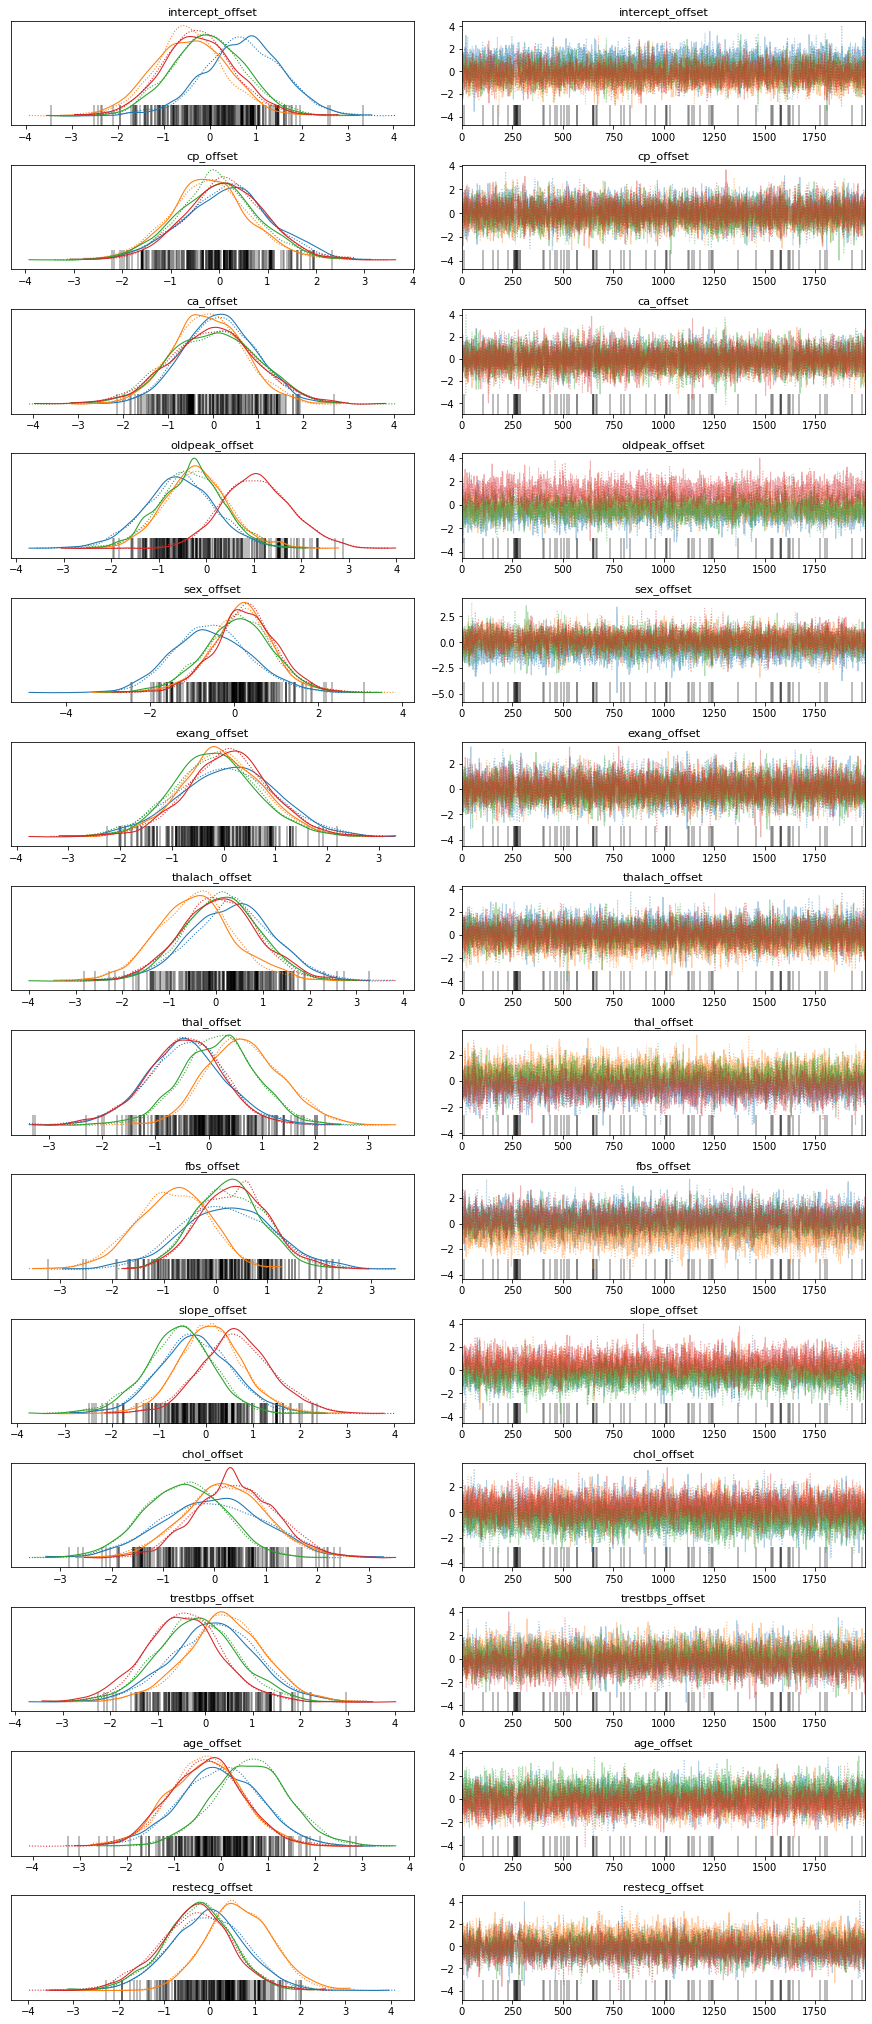

In [ ]:
axes = pm.traceplot(hierarchical_trace, var_names=OFFSETs);
fig = axes.ravel()[0].figure
fig.savefig("hierarchical_trace_full_offset.png")

### Sigma Plots

In [ ]:
f = open("hierarchical_trace_sigma_summary.tex", "w")
f.write(pm.summary(hierarchical_trace, var_names=SIGMAs).to_latex())
f.close()
pm.summary(hierarchical_trace, var_names=SIGMAs)

mean       sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
sigma_intercept   2.765    2.337   0.000  ...    1257.0     880.0    1.0
sigma_cp          0.233    0.264   0.000  ...    1695.0    2088.0    1.0
sigma_ca          2.378    2.865   0.000  ...    1570.0    1811.0    1.0
sigma_oldpeak     3.230    2.211   0.007  ...    1007.0     753.0    1.0
sigma_sex         1.008    1.157   0.001  ...    1373.0    1927.0    1.0
sigma_exang       0.518    0.740   0.000  ...    1523.0    1896.0    1.0
sigma_thalach     1.811    1.709   0.000  ...    1988.0    1022.0    1.0
sigma_thal        0.368    0.375   0.000  ...    1087.0    1285.0    1.0
sigma_fbs         2.004    2.215   0.086  ...    1405.0    1803.0    1.0
sigma_slope       0.975    1.094   0.000  ...     767.0     765.0    1.0
sigma_chol        2.763    2.709   0.005  ...     894.0     837.0    1.0
sigma_trestbps    2.295    2.021   0.006  ...    1828.0    2350.0    1.0
sigma_age         2.314    1.877   0.001  ...    1608.0    1712.0    1.0
sigma_restecg     0.637    0.703   0.000  ...    1038.0     655.0    1.0
sigma_y          24.057  194.307   0.003  ...    6286.0    1731.0    1.0

[15 rows x 9 columns]

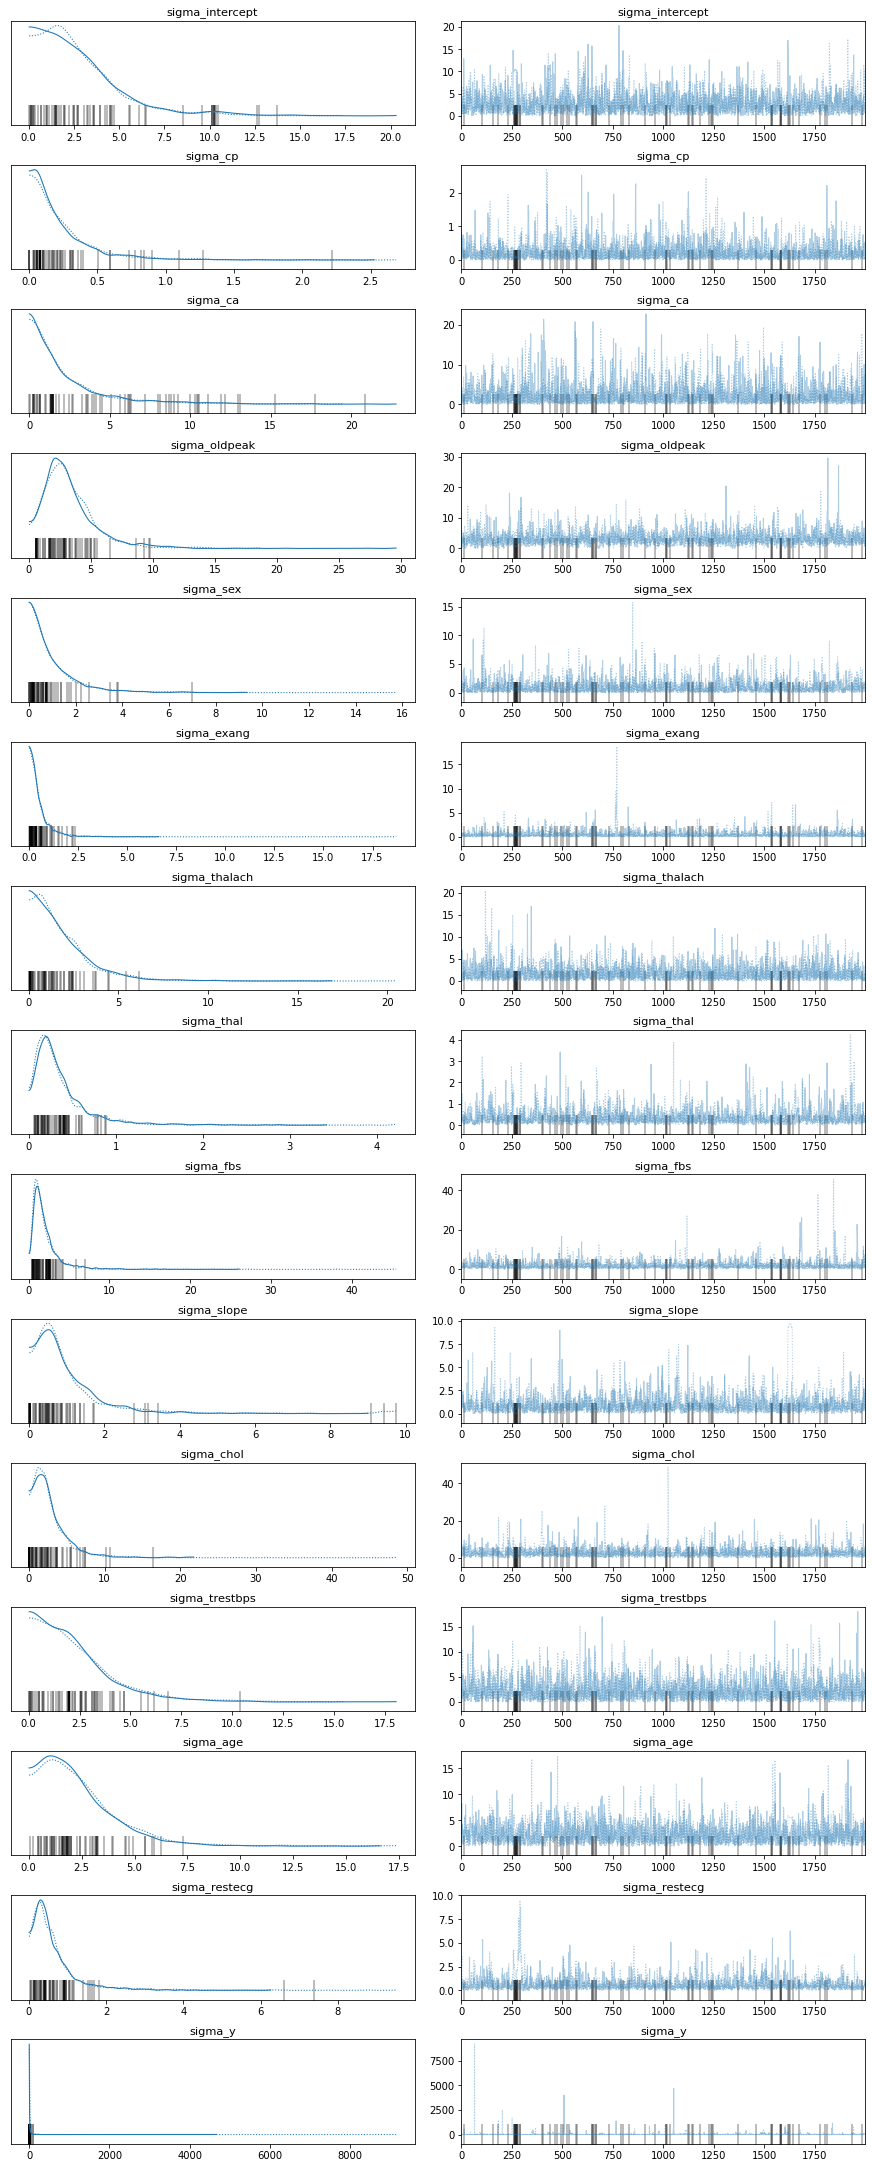

In [ ]:
axes = pm.traceplot(hierarchical_trace, var_names=SIGMAs);
fig = axes.ravel()[0].figure
fig.savefig("hierarchical_trace_full_sigma.png")

### Marginal Plots

In [ ]:
f = open("hierarchical_trace_marginals_summary.tex", "w")
f.write(pm.summary(hierarchical_trace, var_names=OTHERs).to_latex())
f.close()
pm.summary(hierarchical_trace, var_names=OTHERs)

mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
intercept[0] -3.952  3.030  -9.088    1.927  ...    0.051    2165.0    1124.0    1.0
intercept[1] -7.208  1.979 -10.965   -3.600  ...    0.026    3191.0    3729.0    1.0
intercept[2] -6.219  2.031  -9.861   -2.263  ...    0.023    4058.0    3154.0    1.0
intercept[3] -6.720  2.111 -10.830   -2.838  ...    0.025    3633.0    2715.0    1.0
cp[0]         0.787  0.243   0.374    1.290  ...    0.003    3871.0    2863.0    1.0
cp[1]         0.689  0.147   0.403    0.956  ...    0.002    4310.0    3418.0    1.0
cp[2]         0.726  0.161   0.429    1.037  ...    0.002    4152.0    3215.0    1.0
cp[3]         0.765  0.158   0.480    1.064  ...    0.002    3732.0    3496.0    1.0
ca[0]         1.617  0.914   0.060    3.549  ...    0.013    2832.0    2986.0    1.0
ca[1]         1.177  0.245   0.731    1.643  ...    0.003    3577.0    3394.0    1.0
ca[2]         1.455  4.036  -7.336    8.397  ...    0.067    2479.0    1728.0    1.0
ca[3]         1.496  4.326  -7.239    9.225  ...    0.090    2619.0    1728.0    1.0
oldpeak[0]    1.295  2.062  -2.680    5.091  ...    0.029    2894.0    3262.0    1.0
oldpeak[1]    2.472  1.170   0.360    4.692  ...    0.014    3684.0    2999.0    1.0
oldpeak[2]    2.242  1.142   0.018    4.298  ...    0.014    3732.0    3657.0    1.0
oldpeak[3]    5.985  1.645   2.907    9.089  ...    0.026    1914.0    1186.0    1.0
sex[0]        0.312  1.360  -2.385    2.001  ...    0.022    2032.0    2700.0    1.0
sex[1]        1.205  0.389   0.498    1.962  ...    0.004    4056.0    3846.0    1.0
sex[2]        1.121  0.671  -0.212    2.405  ...    0.007    5059.0    3119.0    1.0
sex[3]        1.281  0.394   0.538    2.024  ...    0.004    3979.0    3707.0    1.0
exang[0]      1.145  0.555   0.146    2.313  ...    0.008    3792.0    2616.0    1.0
exang[1]      1.075  0.305   0.502    1.627  ...    0.003    4214.0    3257.0    1.0
exang[2]      1.004  0.326   0.383    1.599  ...    0.004    3607.0    2753.0    1.0
exang[3]      1.149  0.340   0.539    1.821  ...    0.004    3292.0    2899.0    1.0
thalach[0]   -1.084  2.083  -4.661    3.061  ...    0.027    3228.0    3256.0    1.0
thalach[1]   -2.670  1.520  -5.694   -0.023  ...    0.019    3369.0    1398.0    1.0
thalach[2]   -1.611  1.440  -4.281    1.182  ...    0.017    4137.0    3593.0    1.0
thalach[3]   -1.698  1.399  -4.193    1.022  ...    0.016    4039.0    3293.0    1.0
thal[0]      -0.017  0.217  -0.466    0.345  ...    0.003    2552.0    3102.0    1.0
thal[1]       0.300  0.099   0.112    0.484  ...    0.001    2623.0    2768.0    1.0
thal[2]       0.185  0.153  -0.087    0.495  ...    0.002    5020.0    3244.0    1.0
thal[3]       0.012  0.113  -0.191    0.238  ...    0.002    2421.0    2727.0    1.0
fbs[0]        1.475  2.985  -2.557    5.606  ...    0.039    3770.0    2894.0    1.0
fbs[1]       -0.498  0.545  -1.433    0.599  ...    0.007    2888.0    2466.0    1.0
fbs[2]        1.014  0.421   0.188    1.770  ...    0.005    3538.0    3592.0    1.0
fbs[3]        1.230  0.663   0.003    2.418  ...    0.008    3562.0    3566.0    1.0
slope[0]      0.176  0.509  -0.826    1.105  ...    0.008    2617.0    1117.0    1.0
slope[1]      0.443  0.308  -0.114    1.025  ...    0.004    3315.0    3402.0    1.0
slope[2]     -0.015  0.305  -0.592    0.541  ...    0.005    2134.0    1310.0    1.0
slope[3]      0.898  0.543   0.004    1.960  ...    0.008    2068.0    2560.0    1.0
chol[0]       1.084  4.676  -7.026    9.758  ...    0.082    2627.0    1739.0    1.0
chol[1]       1.643  1.771  -1.524    5.093  ...    0.020    4409.0    3371.0    1.0
chol[2]      -0.200  1.018  -2.047    1.691  ...    0.014    2536.0    1473.0    1.0
chol[3]       2.071  1.469  -0.633    4.883  ...    0.020    2532.0    3221.0    1.0
trestbps[0]   1.961  2.479  -2.257    7.322  ...    0.035    3198.0    2624.0    1.0
trestbps[1]   2.331  1.757  -1.058    5.599  ...    0.023    3017.0    2802.0    1.0
trestbps[2]   1.003 

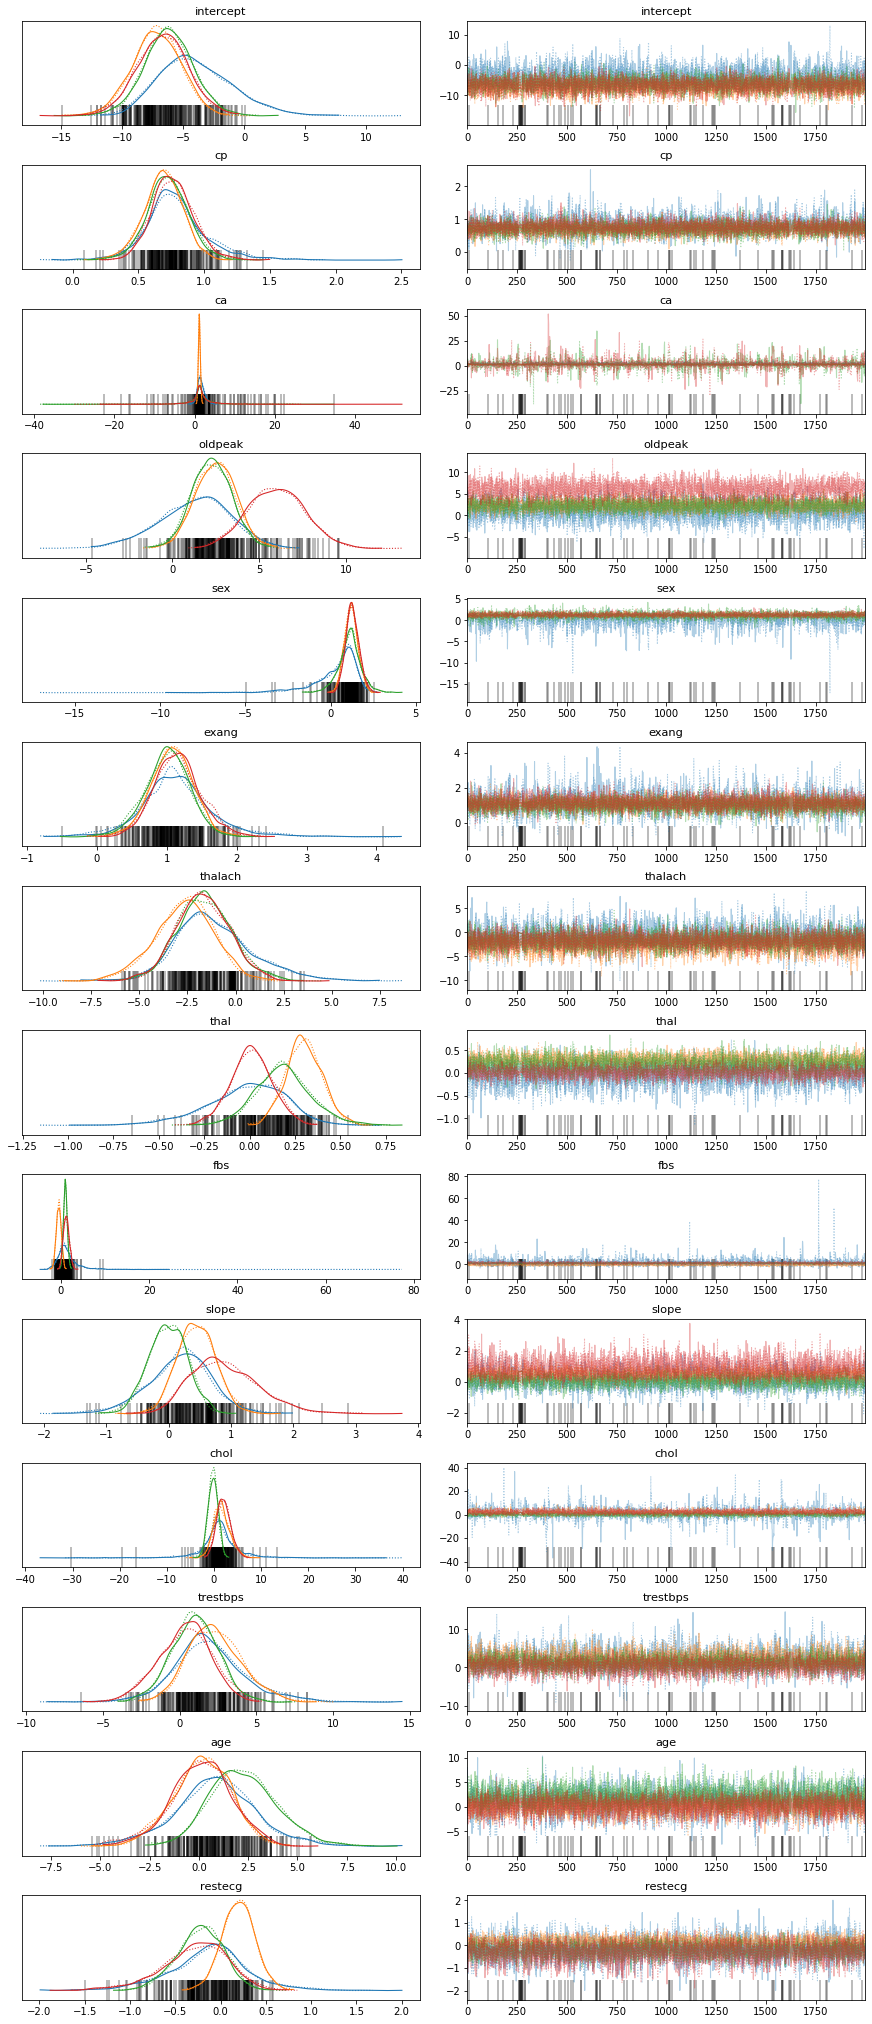

In [ ]:
axes = pm.traceplot(hierarchical_trace, var_names=OTHERs);
fig = axes.ravel()[0].figure
fig.savefig("hierarchical_trace_full_marginals.png")

# Summary Figures and Tables

In [ ]:
df1 = pm.summary(hierarchical_trace, var_names=MUs).sort_values(by=['mean'], ascending=False, key=lambda x: abs(x))

In [ ]:
df2 = pm.summary(trace).sort_values(by=['mean'], ascending=False, key=lambda x: abs(x))

In [ ]:
df3 = result.summary().sort_values(by=['Probability'], ascending=False, key=lambda x: abs(x))

In [ ]:
df1 = df1[['mean','sd','hdi_3%','hdi_97%']]
df2 = df2[['mean','sd','hdi_3%','hdi_97%']]

In [ ]:
f = open("final_summary_hierarchical.tex", "w")
f.write(df1.to_latex())
f.close()

f = open("final_summary_logistic.tex", "w")
f.write(df2.to_latex())
f.close()

f = open("final_summary_BMA.tex", "w")
f.write(df3.to_latex())
f.close()

In [ ]:
! ls *.png

age_histplot.png		       hierarchical_trace_subset.png
ca_histplot.png			       logistic_model_trace_full.png
chol_histplot.png		       logistic_model_trace_subset.png
corr_heatmap.png		       oldpeak_histplot.png
country_histplot.png		       pairplot_by_country.png
cp_histplot.png			       pairplot_by_target.png
exang_histplot.png		       restecg_histplot.png
fbs_histplot.png		       sex_histplot.png
hierarchical_trace_full_marginals.png  slope_histplot.png
hierarchical_trace_full_mu.png	       target_histplot.png
hierarchical_trace_full_offset.png     thalach_histplot.png
hierarchical_trace_full.png	       thal_histplot.png
hierarchical_trace_full_sigma.png      trestbps_histplot.png
hierarchical_trace_subset_mu.png


KeyError: ignored

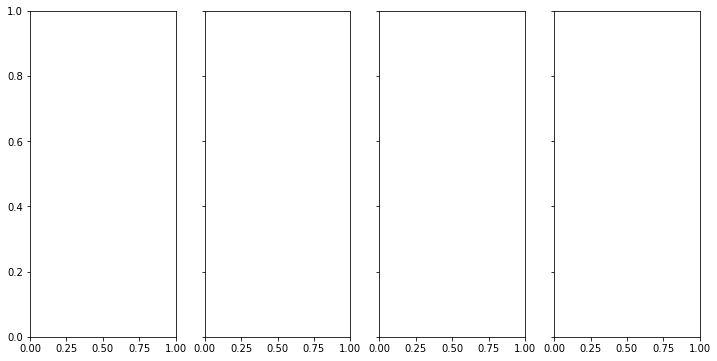

In [ ]:
fig, axis = plt.subplots(1, 4, figsize=(12, 6), sharey=True, sharex=True)

for i in [0,1,2,3]:
    xvals = np.linspace(-0.2, 1.2, 20)
    z = list(df['id'].unique())[i]
    subset = df[df['id'] == z]

    for a,b,c,d,e,f,g,h,ii,j,k,l,m,o  in zip(
                            hierarchical_trace["intercept"][z], 
                            hierarchical_trace["b"][z],
                            hierarchical_trace["c"][z],
                            hierarchical_trace["d"][z],
                            hierarchical_trace["e"][z],
                            hierarchical_trace["f"][z],
                            hierarchical_trace["g"][z],
                            hierarchical_trace["h"][z],
                            hierarchical_trace["i"][z],
                            hierarchical_trace["j"][z],
                            hierarchical_trace["k"][z],
                            hierarchical_trace["l"][z],
                            hierarchical_trace["m"][z],
                            hierarchical_trace["o"][z]):

        axis[i].plot(xvals, 
                      a + (b * xvals) + (c * xvals) + (d * xvals) +\
                     (e * xvals) +\
                     (f * xvals) +\
                     (g * xvals) +\
                     (h * xvals) +\
                     (ii * xvals) +\
                     (j * xvals) +\
                     (k * xvals) +\
                     (l * xvals) +\
                     (m * xvals) +\
                     (o * xvals)  , "g", alpha=0.1)
    axis[i].plot(xvals,
                 hierarchical_trace["intercept"][z].mean() +\
                 hierarchical_trace["b"][z].mean() * xvals +\
                 hierarchical_trace["c"][z].mean() * xvals +\
                 hierarchical_trace["d"][z].mean() * xvals +\
                 hierarchical_trace["e"][z].mean() * xvals +\
                 hierarchical_trace["f"][z].mean() * xvals +\
                 hierarchical_trace["g"][z].mean() * xvals +\
                 hierarchical_trace["h"][z].mean() * xvals +\
                 hierarchical_trace["i"][z].mean() * xvals +\
                 hierarchical_trace["j"][z].mean() * xvals +\
                 hierarchical_trace["k"][z].mean() * xvals +\
                 hierarchical_trace["l"][z].mean() * xvals +\
                 hierarchical_trace["m"][z].mean() * xvals +\
                 hierarchical_trace["o"][z].mean() * xvals , 
            alpha=1,
            lw=2.0,
            label="hierarchical",
        )
    #x = np.array(subset['food']) + (np.random.randn(len(subset))*0.01)
    #y = np.array(subset['sales'])
    #axis[i].scatter(x ,y ,
    #    alpha=1,
    #    color="k",
    #    marker=".",
    #    s=80,
    #    label="original data",
    #)
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(["0", "1"])
    #axis[i].set_ylim(-1, 2)
    axis[i].set_title("Country ID: {}".format(z))
    if not i % 4:
        axis[i].legend()
        axis[i].set_ylabel("y")

# HW 4 Model Building - Testing

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.dtypes

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(df, hue="target")

In [ ]:
df.sample(10)

In [ ]:
n = df.shape[0]
id_country = df.id.unique()
countries = len(id_country)

age	= df.age.values
sex	= df.sex.values
cp	= df.cp.values
trestbps	= df.trestbps.values
chol	= df.chol.values
fbs	= df.fbs.values
restecg	= df.restecg.values
thalach	= df.thalach.values
exang	= df.exang.values
oldpeak	= df.oldpeak.values
slope	= df.slope.values
ca	= df.ca.values
thal	= df.thal.values
target	= df.target
country_ids = df.id.values


In [ ]:
df.dtypes

In [ ]:
with Model() as hierarchical_model:
    # Priors for the fixed effects
    # a - overall intercept
    mu_a = Normal('mu_a', mu=0., sd=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    #b - age
    mu_b = Normal('mu_b', mu=0., sd=1e5)
    sigma_b = HalfCauchy('sigma_b', 5)
    
    #c - sex
    mu_c = Normal('mu_c', mu=0., sd=1e5)
    sigma_c = HalfCauchy('sigma_c', 5)  
    
    mu_d = Normal('mu_d', mu=0., sd=1e5)
    sigma_d = HalfCauchy('sigma_d', 5)
    
    a_offset = Normal('a_offset', mu=0, sd=1, shape=countries)
    a = Deterministic("a", mu_a + a_offset * sigma_a)
    
    b_offset = Normal('b_offset', mu=0, sd=1, shape=countries)
    b = Deterministic("b", mu_b + b_offset * sigma_b)
    
    c_offset = Normal('c_offset', mu=0, sd=1, shape=countries)
    c = Deterministic("c", mu_c + c_offset * sigma_c)

    d_offset = Normal('d_offset', mu=0, sd=1, shape=countries)
    d = Deterministic("d", mu_d + d_offset * sigma_d)
    
    # Residual Error
    sigma_y = HalfCauchy('sigma_y', 5)

    #y_hat = a[country_ids] + b[country_ids]*age + c[country_ids]*sex
    y_hat = a[country_ids] +\
    b[country_ids]*age + c[country_ids]*age*sex +\
    d[country_ids]*fbs

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=target)

In [ ]:
with hierarchical_model:
    hierarchical_trace = sample(1000, n_init=50000, tune=1000)

In [ ]:
pm.traceplot(hierarchical_trace, var_names=["mu_a", "mu_b", "mu_c","mu_d","sigma_a", "sigma_b", "sigma_c", "sigma_d","sigma_y"]);

In [ ]:
pm.traceplot(hierarchical_trace, var_names=["a","b","c","d"]);

In [ ]:
sumframe = pm.summary(hierarchical_trace)

In [ ]:
sumframe.head()

In [ ]:
forestplot(hierarchical_trace, var_names=['a']);

# Additional Resources

https://twiecki.io/blog/2018/08/13/hierarchical_bayesian_neural_network/

https://docs.pymc.io/notebooks/posterior_predictive.html

https://discourse.pymc.io/t/do-we-need-a-testing-set/759/5